In [1]:
import pandas as pd
import numpy as np
import datetime
from darts import TimeSeries, concatenate
from darts.metrics import mape
import plotly.express as px
from copy import deepcopy
import warnings as wr
from darts.models import LinearRegressionModel, XGBModel, LightGBMModel, RandomForestModel, NaiveMovingAverage
from darts.dataprocessing.transformers import WindowTransformer, MissingValuesFiller, InvertibleMapper
from darts.dataprocessing.pipeline import Pipeline
from func_timeout import func_timeout, FunctionTimedOut
import optuna
import json
import re
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from etna.datasets.tsdataset import TSDataset, HierarchicalStructure

pd.options.plotting.backend = "plotly"

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kruglov\AppData\Roaming\Python\Python311\site-packages\etna\settings.py:35: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.

In [2]:
df = pd.read_excel('history.xlsx')

In [4]:
df['date'] = pd.to_datetime(df['Дата'], format='%m_%Y')

In [5]:
df['segment'] = df['Канал'] + '_' + df['Управленческая Линейка'].fillna('пропуск') + '_' + df['Управленческое Наименование'].fillna('пропуск')

In [6]:
df

,Канал,Канал сбыта1,Управленческая Линейка,Управленческое Наименование,Линейка,Бюджетное Наименование,Дата,Количество,Сумма без НДС,date,segment
0,ЦВТ,ЦВТ,NaN,NaN,NaN,NaN,2025-01-01,1.0,916.67,2025-01-01,ЦВТ_пропуск_пропуск
1,АДКМ,АДКМ,NaN,NaN,NaN,NaN,2025-01-02,1.0,273.33,2025-01-02,АДКМ_пропуск_пропуск
2,ЦВТ,ЦВТ,NaN,NaN,NaN,NaN,2025-01-02,15.0,13750.02,2025-01-02,ЦВТ_пропуск_пропуск
3,АДКМ,АДКМ,NaN,NaN,NaN,NaN,2025-01-03,4.0,1128.33,2025-01-03,АДКМ_пропуск_пропуск
4,ЦВТ,ЦВТ,NaN,NaN,NaN,NaN,2025-01-03,13.0,10816.68,2025-01-03,ЦВТ_пропуск_пропуск
...,...,...,...,...,...,...,...,...,...,...,...
492041,АДКМ,АДКМ,NaN,"ЯНОВА Шираз Семигорья Сухое Красное 0,75 л.",Прочие АТВ,NaN,2022-12-18,2.0,4014.17,2022-12-18,АДКМ_пропуск_ЯНОВА Шираз Семигорья Сухое Красн...
492042,АТВ,АТВ,NaN,"ЯНОВА Шираз Семигорья Сухое Красное 0,75 л.",Прочие АТВ,NaN,2022-12-24,6.0,10359.92,2022-12-24,АТВ_пропуск_ЯНОВА Шираз Семигорья Сухое Красно...
492043,АТВ,АТВ,NaN,"ЯНОВА Шираз Семигорья Сухое Красное 0,75 л.",Прочие АТВ,NaN,2022-12-25,2.0,3669.17,2022-12-25,АТВ_пропуск_ЯНОВА Шираз Семигорья Сухое Красно...
492044,АТВ,АТВ,NaN,"ЯНОВА Шираз Семигорья Сухое Красное 0,75 л.",Прочие АТВ,NaN,2022-12-28,1.0,2158.33,2022-12-28,АТВ_пропуск_ЯНОВА Шираз Семигорья Сухое Красно...


In [7]:
df = df.groupby(['segment', pd.Grouper(key='Дата', freq='M')], as_index=False)['Количество'].sum()

C:\Users\Kruglov\AppData\Local\Temp\ipykernel_3212\2497279514.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.groupby(['segment', pd.Grouper(key='Дата', freq='M')], as_index=False)['Количество'].sum()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51770 entries, 0 to 51769
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   segment     51770 non-null  object        
 1   Дата        51770 non-null  datetime64[ns]
 2   Количество  51770 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [9]:
df.rename(columns={'Дата':'timestamp', 'Количество':'target'}, inplace=True)

In [10]:
ts = TSDataset(df, freq="M")

C:\Users\Kruglov\AppData\Roaming\Python\Python311\site-packages\etna\datasets\tsdataset.py:145: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self._freq: Optional[pd.DateOffset] = pd.tseries.frequencies.to_offset(freq)


In [11]:
ts_describe = ts.describe().sort_values(by='length', ascending=False)

In [12]:
ts_describe.sort_values(by='start_timestamp')

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
"АТВ_пропуск_HANDELSHOF Шнапс Груша 0,02 л.",2022-01-31,2025-08-31,44,27,3839,0,0,0,ME
"АТВ_пропуск_ФРШ ВИ ЗНМП выдерж. ЭКСТРА брют белое «Фрешенет Брют Барроко Резерва Кава» 0,75",2022-01-31,2025-08-31,44,11,3839,0,0,0,ME
"АТВ_пропуск_УП Шардоне Сухое Белое 0,75 л.",2022-01-31,2025-08-31,44,2,3839,0,0,0,ME
"АТВ_пропуск_УП Шардоне Резерв Сухое Белое 0,75 л.",2022-01-31,2025-08-31,44,1,3839,0,0,0,ME
"АТВ_пропуск_УП Совиньон Сухое Белое 0,75 л.",2022-01-31,2025-08-31,44,43,3839,0,0,0,ME
...,...,...,...,...,...,...,...,...,...
"ТД Регион_пропуск_""Блан де Блан"" Белое Экстра брют 0,75",2025-08-31,2025-08-31,1,0,3839,0,0,0,ME
"ЦВТ_Коньяк 1870_Коньяк 1870 КВВК 0,05",2025-08-31,2025-08-31,1,0,3839,0,0,0,ME
"ТД Регион_пропуск_""Бубновый Валет"" Красное Полусладкое 0,75",2025-08-31,2025-08-31,1,0,3839,0,0,0,ME


In [13]:
df

,segment,timestamp,target
0,A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Красное ...,2024-09-30,120.0
1,A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Красное ...,2024-12-31,600.0
2,A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Розовое ...,2024-12-31,120.0
3,A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Амурский ...,2024-09-30,96.0
4,A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Амурский ...,2024-12-31,432.0
...,...,...,...
51765,прочее_пропуск_УП Каберне Совиньон Сухое Красн...,2024-11-30,2.0
51766,прочее_пропуск_УП Пино Нуар Резерв Сухое Красн...,2025-03-31,1.0
51767,прочее_пропуск_Шато де Талю Блан Сухое Белое 0...,2025-03-31,2.0
51768,прочее_пропуск_Шато де Талю Розе Сухое розовое...,2025-03-31,2.0


In [14]:
df['target'] = np.where(df['target'] < 0, 0, df['target'])


In [15]:
describe_list = []

for i in df['segment'].unique():
    print(i)
    segment_data = {}
    segment_data['segment'] = i
    ts = df[df['segment']==i]
    ts = TimeSeries.from_dataframe(ts.drop('segment', axis=1), time_col='timestamp', freq='M')
    end_time = ts.end_time()
    start_time = ts.start_time()
    longest_period = ts.longest_contiguous_slice().shape[0]
    ts_length = ts.shape[0]
    df_ts = ts.to_dataframe().fillna(0)
    zero_count = df_ts.isin([0]).sum().sum()
    var = round(df_ts.std().iloc[0], 2)
    
    segment_data['end_time'] = end_time
    segment_data['start_time'] = start_time
    segment_data['zero_count'] = zero_count
    segment_data['longest_period'] = longest_period
    segment_data['ts_length'] = ts_length
    segment_data['var'] = var
    
    describe_list.append(segment_data)

A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс  Розовое Сухое 0,75
A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75
A2Z_внеш_Абрау Эстейтс_Абрау Эстейтс Достойный Красное Сухое 0,75
A2Z_внеш_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Брют 0,75
A2Z_внеш_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
A2Z_внеш_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
A2Z_внеш_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
A2Z_внеш_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
A2Z_внеш_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
A2Z_внеш_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
A2Z_внеш_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
A2Z_внеш_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
A2Z_внеш_ВВ_ВВ  Белое Сухое 0,75
A2Z_внеш_ВВ_ВВ  Розовое Сухое 0,75
A2Z_внеш_ВВ_ВВ Голубок Красное Сухое 0,75
A2Z_внеш_ВВ_

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

A2Z_внеш_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
A2Z_внеш_ВВ_ВВ Красностоп Розовое Сухое 0,75
A2Z_внеш_ВВ_ВВ Сибирьковый Белое Сухое 0,75
A2Z_внеш_ВВР_ВВР  Белое Сухое 0,75
A2Z_внеш_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
A2Z_внеш_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
A2Z_внеш_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
A2Z_внеш_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
A2Z_внеш_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
A2Z_внеш_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
A2Z_внеш_Д Ор_Д Ор Рислинг Белое Брют 0,75
A2Z_внеш_Д Ор_Д Ор Розе Розовое Брют 0,75
A2Z_внеш_Дравиньи_Дравиньи  Белое Брют 0,75
A2Z_внеш_Дравиньи_Дравиньи  Белое Полусладкое 0,75
A2Z_внеш_Дравиньи_Дравиньи  Белое Полусухое 0,75
A2Z_внеш_Дравиньи_Дравиньи  Белое Экстра брют 0,75
A2Z_внеш_Дравиньи_Дравиньи  Красное Полусладкое 0,75
A2Z_внеш_Дравиньи_Дравиньи  Розовое Брют 0,75
A2Z_внеш_Империал_Империал П/У  Розе Розовое Брют 0,75
A2Z_вн

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

A2Z_внеш_Империал_Империал Розе Розовое Брют 9
A2Z_внеш_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
A2Z_внеш_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
A2Z_внеш_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
A2Z_внеш_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
A2Z_внеш_РШ_РШ  Белое Брют 0,2
A2Z_внеш_РШ_РШ  Белое Брют 0,75
A2Z_внеш_РШ_РШ  Белое Полусладкое 0,2
A2Z_внеш_РШ_РШ  Белое Полусладкое 0,75
A2Z_внеш_РШ_РШ  Белое Полусухое 0,75
A2Z_внеш_РШ_РШ  Белое Сладкое 0,75
A2Z_внеш_РШ_РШ  Красное Полусладкое 0,75
A2Z_внеш_РШ_РШ  Розовое Полусухое 0,2
A2Z_внеш_РШ_РШ  Розовое Полусухое 0,75
A2Z_внеш_РШ_РШ Sparkling Wine Abrau-Durso,Semi-Sweet White Белое Полусладкое 0,75
A2Z_внеш_пропуск_Sheki Wines Shirvan Vadisi Semi-Dry Red Wine Красное Полусухое 0,75
A2Z_внеш_пропуск_Вино  сухое белое Шеки Вайнс Селект_э
A2Z_внеш_пропуск_Вино  сухое красное Шеки Вайнс Селект_э
A2Z_внеш_пропуск_Вино игристое Шеки Вайнс белое брют_э
A2Z_внеш_пропуск_Вино игристое Шеки Вайнс белое брют_э Белое Полуслад

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_7 овощей_7 овощей  0,5
АДКМ_7 овощей_7 овощей  0,7
АДКМ_7 овощей_7 овощей  1,5
АДКМ_Абрау Винонад_Абрау Винонад "Абрау Винонад со вкусом Черешни и Винограда"  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Беллини  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Ананаса и Винограда  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Манго и Винограда  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Пина Колада  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Пино Нуар  Напиток газированный 0,375
АДКМ_Абрау Винонад_Абрау Винонад со вкусом Траминер  Напиток газированн

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,25
АДКМ_Абрау Лайт стар_Абрау Лайт стар  Розовое Полусладкое 0,25
АДКМ_Абрау Спуманте_Абрау Спуманте  Белое Брют 0,75
АДКМ_Абрау Спуманте_Абрау Спуманте  Белое Полусухое 0,75
АДКМ_Абрау Спуманте_Абрау Спуманте  Розовое Брют 0,75
АДКМ_Абрау Фиори_Абрау Фиори полусладкий Белое Резервуарный 0,75
АДКМ_Абрау Фиори_Абрау Фиори полусладкий Красное Резервуарный 0,75
АДКМ_Абрау Фиори_Абрау Фиори полусладкий Розовое Резервуарный 0,75
АДКМ_Абрау Фиори_Абрау Фиори сладкий Белое Резервуарный 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс  Розовое Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Достойный Красное Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Каберне Совиньон Белое Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Оранж Белое Сухое 0,75
АДКМ_Абрау Эстейтс_Абрау Эстейтс Фам д

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
АДКМ_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
АДКМ_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
АДКМ_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
АДКМ_Аперитив Абрау_Аперитив Абрау  0,7
АДКМ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 30*70 Красное Сухое 0,75
АДКМ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 30*70 Красное Сухое 1,5
АДКМ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 50*50 Красное Сухое 0,75
АДКМ_ВВ_ВВ  Белое Сухое 0,75
АДКМ_ВВ_ВВ  Розовое Сухое 0,75
АДКМ_ВВ_ВВ Ассамбляж Белое Сухое 0,75
АДКМ_ВВ_ВВ Голубок Красное Сухое 0,75
АДКМ_ВВ_ВВ Каберне Красное Сухое 0,75
АДКМ_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
АДКМ_ВВ_ВВ Красностоп Розовое Сухое 0,75
АДКМ_ВВ_ВВ Пухляковский Белое Сухое 0,75
АДКМ_ВВ_ВВ Сибирьковый Белое Сухое 0,75
АДКМ_ВВР_ВВР  Белое Сухое 0,75
АДКМ_ВВР_ВВР  Красное Сухое 0,75
АДКМ_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
АДКМ_ВВР

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
АДКМ_ВВР_ВВР Ркацители Белое Сухое 0,75
АДКМ_ВВР_ВВР Ркацители выдержаное в дубе Белое Сухое 0,75
АДКМ_ВВР_ВВР Сибирьковый Белое Экстра брют 0,75
АДКМ_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
АДКМ_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
АДКМ_ВВЪ_ВВЪ выдер 2020 Дер. короб. Красное Сухое 0,75
АДКМ_ВВЪ_ВВЪ выдер 2020 Красное Сухое 0,75
АДКМ_ВВЪ_ВВЪ выдер 2020 П/У Красное Сухое 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Алиготе Белое Брют 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Голубок Красное Брют 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Красностоп Красное Полусухое 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Пино-Нуар Розовое Брют 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Платовский Белое Брют 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Платовский-Алиготе Белое Брют 0,75
АДКМ_Ведерников Пет-Нат_Ведерников Пет-Нат Рислинг Белое Брют 0,75
АДКМ_Ведер

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
АДКМ_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
АДКМ_Водка особая 7 злаков_Водка 7 злаков  0,7 л.
АДКМ_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
АДКМ_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
АДКМ_Д Ор_Д Ор Рислинг Белое Брют 0,75
АДКМ_Д Ор_Д Ор Розе Розовое Брют 0,75
АДКМ_Джин 7 трав_Джин 7 трав  0,5
АДКМ_Джин 7 трав_Джин 7 трав  0,7
АДКМ_Джин Хамелеон_Джин Хамелеон  0,5
АДКМ_Джин Хамелеон_Джин Хамелеон  0,7
АДКМ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Брют 1,5
АДКМ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Экстра брют 1,5
АДКМ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Нуар Белое Экстра брют 0,75
АДКМ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Нуар Белое Экстра брют 1,5
АДКМ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Гранд Кюве Белое Брют 0,75
АДКМ_Дивноморье игристое выдержанное

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_Дравиньи_Дравиньи  Белое Брют 1,5
АДКМ_Дравиньи_Дравиньи  Белое Полусладкое 0,75
АДКМ_Дравиньи_Дравиньи  Белое Полусухое 0,75
АДКМ_Дравиньи_Дравиньи  Белое Экстра брют 0,75
АДКМ_Дравиньи_Дравиньи  Красное Полусладкое 0,75
АДКМ_Дравиньи_Дравиньи  Розовое Брют 0,375
АДКМ_Дравиньи_Дравиньи  Розовое Брют 0,75
АДКМ_Дравиньи_Дравиньи П/У Белое Брют 0,75
АДКМ_Дравиньи_Дравиньи П/У Розовое Брют 0,75
АДКМ_Жемчужное_Жемчужное "Абрау Коллекшен" Белое Брют 0,25
АДКМ_Жемчужное_Жемчужное "Абрау Коллекшен" Розовое Брют 0,25
АДКМ_Жемчужное_Жемчужное "Абрау Физз" Белое Брют 0,25
АДКМ_Жемчужное_Жемчужное "Абрау Физз" Розовое Брют 0,25
АДКМ_Империал_Империал Винтаж Белое Брют 0,75
АДКМ_Империал_Империал Винтаж Белое Брют 1,5
АДКМ_Империал_Империал П/У  Розе Розовое Брют 0,75
АДКМ_Империал_Империал П/У Винтаж Белое Брют 0,75
АДКМ_Империал_Империал П/У Винтаж Белое Брют 1,5
АДКМ_Империал_Империал П/У Винтаж Белое Брют 3
АДКМ_Империал_Империал П/У Винтаж Белое Брют 6
АДКМ_Империал_Империал П/У Винтаж Б

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
АДКМ_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
АДКМ_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
АДКМ_Купаж Абрау_Купаж Абрау 0,75 2024
АДКМ_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
АДКМ_Кюве Александр II_Кюве Александр II П/У Белое Брют 0,75
АДКМ_Масло виноградной косточки_Масло виноградной косточки  0,25
АДКМ_Миллезим_Миллезим 1979 Белое Брют 0,75
АДКМ_Миллезим_Миллезим 1988 Белое Брют 0,75
АДКМ_Миллезим_Миллезим 2001 Белое Брют 0,75
АДКМ_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
АДКМ_Портвейн Агдам_Портвейн Агдам  Красное Сладкое 0,75
АДКМ_РШ_РШ  Белое Брют 0,2
АДКМ_РШ_РШ  Белое Брют 0,75
АДКМ_РШ_РШ  Белое Полусладкое 0,2
АДКМ_РШ_РШ  Белое Полусладкое 0,75
АДКМ_РШ_РШ  Белое Полусухое 0,75
АДКМ_РШ_РШ  Красное Полусладкое 0,75
АДКМ_РШ_РШ  Розовое Полусухое 0,2
АДКМ_РШ_РШ  Розовое Полусухое 0,75
АДКМ_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго Белый 0,7
АДКМ_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго ДАНСА ДЕЛЬ ФУЭГ

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_"Мерло" Сухое Красное 0,75 л.
АДКМ_пропуск_"Николаев и Сыновья Полет шмеля 19" Сухое Белое 0,75 л.
АДКМ_пропуск_"Николаев и Сыновья Полет шмеля" Белое Сухое 0,75
АДКМ_пропуск_"Николаев и Сыновья Сира 21" Сухое Красное 0,75 л.
АДКМ_пропуск_"Николаев и Сыновья Сира 22" Красное Сухое 0,75
АДКМ_пропуск_"Патрей. Базилевс Сатир" Белое Сухое 0,75
АДКМ_пропуск_"Пет Нат Неретинский" Розовое Экстра брют 0,75
АДКМ_пропуск_"Пино Фран" Сухое Красное 0,75 л.
АДКМ_пропуск_"РИСЛИНГ. СЕМЕЙНЫЙ РЕЗЕРВ" Белое Сухое 0,75
АДКМ_пропуск_"РКАЦИТЕЛИ СЮР ЛИ" ТЗ "ЕССЕ" Белое Сухое 0,75
АДКМ_пропуск_"РОЗЕ"  Розовое Сухое 0,75
АДКМ_пропуск_"СОВИНЬОН БЛАН"  Сухое Белое 0,75 л.
АДКМ_пропуск_"СОВИНЬОН БЛАН" ТЗ "ЕССЕ" Белое Сухое 0,75
АДКМ_пропуск_"СОВИНЬОН БЛАН. СЕМЕЙНЫЙ РЕЗЕРВ" Белое Сухое 0,75
АДКМ_пропуск_"Саперави Каберне Совиньон" Красное Сухое 0,75
АДКМ_пропуск_"Саперави Северный" Сухое Красное 0,75 л.
АДКМ_пропуск_"Сира 747" серия "Ле К2" Красное Сухое 0,75
АДКМ_пропуск_"Совиньон Блан" Сухое Белое 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_ВКСАТЕРА "СЕЛЛАР МАСТЕР ШАРДОНЕ СЕВАСТОПОЛЯ" Сухое Белое 0,75 л.
АДКМ_пропуск_ВКСАТЕРА "Сира" Сухое Красное 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Алиготе Репин Олег Сухое Белое 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Каберне Репин Олег Сухое Красное 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Пино Блан Репин Олег Сухое Белое 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Пино Нуар Бетон Репин Олег Сухое Красное 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Пино Нуар Репин Олег Сухое Красное 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Рислинг Репин Олег Сухое Белое 0,75 л.
АДКМ_пропуск_ВКСАТЕРА Рислинг Репин Олег Сухое Белое 1,5 л.
АДКМ_пропуск_ВКСАТЕРА Сира Репин Олег Сухое Красное 0,75 л.
АДКМ_пропуск_ВКСАТЕРА ЭВОЛЮШН ПИНО НУАР 2022 Сухое Розовое 0,75 л.
АДКМ_пропуск_ВС выдерж. сухое красное «Зисола Ахиллес» 0,75
АДКМ_пропуск_ВС выдерж. сухое красное «Зисола Сицилия Ното Россо» 0,75
АДКМ_пропуск_ВС выдерж. сухое красное «Зисола Сицилия Ното Россо» 1,5
АДКМ_пропуск_ВС выдерж. сухое красное «Фонтерутоли Кьянти Классико» 0,75
АДКМ_пропуск_ВС сухое бело

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_ДИ Западный склон Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Каберне Совиньон Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Мальбек-Каладок Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Марселан Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Мускат розовое Сладкое Розовое 0,5 л.
АДКМ_пропуск_ДИ Пино Блан Сухое Белое 0,75 л.
АДКМ_пропуск_ДИ Пино Нуар Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ РЕБО Сухое Красное 1,5 л.
АДКМ_пропуск_ДИ РЕБО сухое красное 0,75 л.
АДКМ_пропуск_ДИ Рислинг Сухое Белое 0,75 л.
АДКМ_пропуск_ДИ Санджовезе-монтепульчано-примитиво Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Сира Сухое Красное 0,75 л.
АДКМ_пропуск_ДИ Траминер Сухое Белое 0,75 л.
АДКМ_пропуск_ДС "Красностоп Золотовский" Сухое Красное 0,75 л.
АДКМ_пропуск_ДС Красностоп Золотовский Сухое Красное 0,75 л.
АДКМ_пропуск_ДС София Семигорье Сухое Белое 0,75 л.
АДКМ_пропуск_ДС София Семигорье Сухое Красное 0,75 л.
АДКМ_пропуск_ДУБИНИН «Розе» Брют Розовое 0,75 л.
АДКМ_пропуск_ДУБИНИН «Розе» Экстра брют Розовое 0,75 л.
АДКМ_пропуск_ДЭСОН

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_МУХИН Мальвазия оранж Сухое Белое 0,75 л.
АДКМ_пропуск_МУХИН Марселан резерв Сухое Красное 0,75 л.
АДКМ_пропуск_Мерло де Талю сухое красное 0,75 л
АДКМ_пропуск_Мухин Саперави Красное Сухое 0,75
АДКМ_пропуск_НОВОЗАВ "АЛИГОТЕ" серия "ВИНО И НЕБО"  Сухое Белое 0,75 л.
АДКМ_пропуск_НОВОЗАВ "Анемона" серия "Уан Баррел" Сухое Розовое 0,75 л.
АДКМ_пропуск_НОВОЗАВ "Винодельня Новозаведенное. Сильванер" Полусладкое Белое 0,75 л.
АДКМ_пропуск_НОВОЗАВ "ПетНат Понаехали. Виктор Сташко" Экстра брют Белое 0,75 л.
АДКМ_пропуск_НТ «Тристория. Резерв. Красное" Сухое Красное 0,75 л.
АДКМ_пропуск_Пино гри Белое Экстра брют 0,75
АДКМ_пропуск_Пино нуар Красная Горка Сухое Красное 0,75 л.
АДКМ_пропуск_Пино нуар Красное Сухое 0,75
АДКМ_пропуск_Пино нуар Розовое Экстра брют 0,75
АДКМ_пропуск_Портвейн крепленое вино крепкое выдерж. ДОК «Винтаж Порто» 0,75 2000
АДКМ_пропуск_Портвейн крепленое вино крепкое марочное ДОК «Лэйт Боттлед Винтаж Порто» 0,75 2014
АДКМ_пропуск_РЕБЕЛ.ЭППЛ "ТАЙМ КИЛЛА КОНОПЛЯ

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_СК.БЕРЕГ «Скалистый берег. Совиньон Блан» Сухое Белое 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ ГН Кубань Каберне Совиньон Резерв Сухое Красное 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ ГН Кубань Рислинг Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ Каберне Совиньон резерв 2009 Вилла Виктория Сухое Красное 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ Каберне Фран Семигорье Вилла Виктория Сухое Красное 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ Рислинг позднего сбора 2017 Сладкое Белое 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ София Семигорье Сухое Красное 0,75 л.
АДКМ_пропуск_СОМЕЛЬЕ Шардоне Позднего Сбора Семигорье Полусладкое Белое 0,75 л.
АДКМ_пропуск_СОЧЬЕТА "Грейт Волл Файв Стар Каберне Совиньон" Сухое Красное 0,75 л.
АДКМ_пропуск_СПАСИБ "Саперави" Сухое Красное 0,7 л.
АДКМ_пропуск_СУХОВ "Каберне Совиньон Сухое Красное 0,75 л.
АДКМ_пропуск_Совиньон блан Красная Горка Сухое Белое 0,75 л.
АДКМ_пропуск_Совиньон де Талю сухое белое 0,75 л
АДКМ_пропуск_ТАВР "Иван и Ксения Круз. Л Элеганс. Совиньон Блан 2022" Сухое Белое 0,75 л.
АДКМ_пропу

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_УП Каберне Совиньон и Мерло 1890 Сухое Красное 0,75 л.
АДКМ_пропуск_УП Мерло и Каберне Совиньон Сухое Красное 0,75 л.
АДКМ_пропуск_УП Пино Гри Бельмас Сухое Белое 0,75 л.
АДКМ_пропуск_УП Пино Нуар 1890 Сухое Красное 0,75 л.
АДКМ_пропуск_УП Пино Нуар Резерв Сухое Красное 0,75 л.
АДКМ_пропуск_УП Пино Нуар. Бельмас Сухое Красное 0,75 л.
АДКМ_пропуск_УП Рислинг Бельмас Сухое Белое 0,75 л.
АДКМ_пропуск_УП Розовое Сухое Розовое 0,75 л.
АДКМ_пропуск_УП САПЕРАВИ" ТЗ "ДВА СЕРДЦА" Сухое Красное 0,75 л.
АДКМ_пропуск_УП Совиньон Блан серия "Ле К2" Сухое Белое 0,75 л.
АДКМ_пропуск_УП Шардоне Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_УП Шардоне Сухое Белое 0,75 л.
АДКМ_пропуск_ФВД "Пино Гриджио Шардоне" "АГОРА" "КЮВЕ" Брют Белое 0,75 л.
АДКМ_пропуск_ФВД "Пино Нуар Шардоне" "АГОРА" "КЮВЕ" Брют Розовое 0,75 л.
АДКМ_пропуск_ФРШ ВИ ЗНМП выдерж. ЭКСТРА брют белое «Фрешенет Брют Барроко Резерва Кава» 0,75
АДКМ_пропуск_ФРШ ВИ ЗНМП выдерж. ЭКСТРА брют белое «Фрешенет Винтаж Резерва Кава» 0,75
АДК

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АДКМ_пропуск_ШЕЛАЕВ Рислинг Брют Белое 0,75 л.
АДКМ_пропуск_ШТДА Шато Д'Авиз Экстра брют Белое 0,75 л.
АДКМ_пропуск_ШТДА Шато д’ Авиз. Кото Шампенуа Блан Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Блан Сухое Белое 0,375 л.
АДКМ_пропуск_Шато де Талю Блан Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Клере Сухое Розовое 0,75 л.
АДКМ_пропуск_Шато де Талю Мускат Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Розе Сухое розовое 0,75 л.
АДКМ_пропуск_Шато де Талю Руж Сухое Красное 0,375 л.
АДКМ_пропуск_Шато де Талю Руж Сухое Красное 0,75 л.
АДКМ_пропуск_Шато де Талю Совиньон Блан Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Шардоне Резерв Сухое Белое 0,75 л.
АДКМ_пропуск_Шато де Талю Шираз Сухое Красное 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Совиньон Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Фран Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю сухое красное "Шато де Талю Красностоп Резерв" 0,75 л.
АДКМ_пропуск_Шато де Талю

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_4 воды_4 воды Виноградная  Питьевая вода 0,75
АТВ_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
АТВ_4 воды_4 воды газ  Питьевая вода 0,375
АТВ_4 воды_4 воды газ  Питьевая вода 0,75
АТВ_4 воды_4 воды негаз  Питьевая вода 0,375
АТВ_4 воды_4 воды негаз  Питьевая вода 0,75
АТВ_7 овощей_7 овощей  0,5
АТВ_7 овощей_7 овощей  0,7
АТВ_7 овощей_7 овощей  1,5
АТВ_Абрау Винонад_Абрау Винонад "Абрау Винонад со вкусом Черешни и Винограда"  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад Беллини  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад со вкусом Ананаса и Винограда  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газированный 0,375
АТВ_Абрау Винонад_Абрау Винонад со вкусом Манго и Виног

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
АТВ_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
АТВ_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
АТВ_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
АТВ_Аперитив Абрау_Аперитив Абрау  0,7
АТВ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 30*70 Красное Сухое 0,75
АТВ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 30*70 Красное Сухое 1,5
АТВ_ВВ Фантом_ВВ Фантом Красностоп Золотовский-Каберне Совиньон 50*50 Красное Сухое 0,75
АТВ_ВВ_ВВ  Белое Сухое 0,75
АТВ_ВВ_ВВ  Красное Сухое 0,75
АТВ_ВВ_ВВ  Розовое Сухое 0,75
АТВ_ВВ_ВВ Ассамбляж Белое Сухое 0,75
АТВ_ВВ_ВВ Голубок Красное Сухое 0,75
АТВ_ВВ_ВВ Каберне Красное Сухое 0,75
АТВ_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
АТВ_ВВ_ВВ Красностоп Розовое Сухое 0,75
АТВ_ВВ_ВВ Пухляковский Белое Сухое 0,75
АТВ_ВВ_ВВ Сибирьковый Белое Сухое 0,75
АТВ_ВВР_ВВР  Белое Сухое 0,75
АТВ_ВВР_ВВР  Красное Сухое 0,75
АТВ_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,7

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_Ведерников игристое_Ведерников игристое Цимлянский черный выдержанное Розовое Брют 0,75
АТВ_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
АТВ_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
АТВ_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
АТВ_Водка особая 7 злаков_Водка 7 злаков  0,7 л.
АТВ_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
АТВ_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
АТВ_Д Ор_Д Ор Рислинг Белое Брют 0,75
АТВ_Д Ор_Д Ор Розе Розовое Брют 0,75
АТВ_Джин 7 трав_Джин 7 трав  0,5
АТВ_Джин 7 трав_Джин 7 трав  0,7
АТВ_Джин Хамелеон_Джин Хамелеон  0,5
АТВ_Джин Хамелеон_Джин Хамелеон  0,7
АТВ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Брют 0,75
АТВ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Брют 1,5
АТВ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Экстра брют 1,5
АТВ_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Нуар Белое Брют 0,75
АТВ_Дивноморье игрис

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_Коньяк 1870_Коньяк 1870 КВВК 0,05
АТВ_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
АТВ_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
АТВ_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
АТВ_Коньяк Ширван_Коньяк Ширван  0,7
АТВ_Коньяк Ширван_Коньяк Ширван П/У 0,7
АТВ_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
АТВ_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
АТВ_Купаж Абрау_Купаж Абрау 0,75 2024
АТВ_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
АТВ_Кюве Александр II_Кюве Александр II П/У Белое Брют 0,75
АТВ_Масло виноградной косточки_Масло виноградной косточки  0,25
АТВ_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
АТВ_Портвейн Агдам_Портвейн Агдам  Красное Сладкое 0,75
АТВ_Правобережное (СТМ)_Вино сухое белое "Донская коллекция"
АТВ_Правобережное (СТМ)_Вино сухое красное "Донская коллекция"
АТВ_Правобережное (СТМ)_Правобережное (СТМ)  Красное Полусухое 0,75
АТВ_РШ_РШ  

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_"Кокур" Белое Сухое 0,75
АТВ_пропуск_"Королевское Восстание Против Пепина"  Классический 0,75
АТВ_пропуск_"Купаж № 132" Сухое Красное 0,75 л.
АТВ_пропуск_"Мадера" Белое Сладкое 0,75
АТВ_пропуск_"Мерло" Сухое Красное 0,75 л.
АТВ_пропуск_"Мерло" Сухое Розовое 0,75 л.
АТВ_пропуск_"Мерло. Серия ВЛ" Красное Сухое 0,75
АТВ_пропуск_"Мускат" Сухое Белое 0,75 л.
АТВ_пропуск_"Николаев и Сыновья Каберне Фран 20" Сухое Красное 0,75 л.
АТВ_пропуск_"Николаев и Сыновья Полет шмеля 19" Сухое Белое 0,75 л.
АТВ_пропуск_"Николаев и Сыновья Полет шмеля" Белое Сухое 0,75
АТВ_пропуск_"Николаев и Сыновья Совиньон Блан 22" Сухое Белое 0,75 л.
АТВ_пропуск_"ПИНО НУАР ТЕМПЕЛЬХОФ" Красное Сухое 0,75
АТВ_пропуск_"Патрей. Базилевс Сатир" Белое Сухое 0,75
АТВ_пропуск_"Пино Нуар. Домен Липко" Красное Сухое 0,75
АТВ_пропуск_"Пино Фран" Сухое Красное 0,75 л.
АТВ_пропуск_"Портвейн Крымский Солнечной Долины" Сладкое Белое 0,75 л.
АТВ_пропуск_"РИСЛИНГ. ДОМЕН БОНАМИ" Белое Сухое 0,75
АТВ_пропуск_"РОЗЕ"  Розовое

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,02 л.
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,5
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Ревень-Ваниль 0,5
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,02
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,5
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Терн 0,5
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,02
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,5
АТВ_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Яблоко 0,02 л.
АТВ_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Баварский Биттер 0,5 л
АТВ_пропуск_HANDELSHOF Шнапс Вишня 0,7 л.
АТВ_пропуск_HANDELSHOF Шнапс Груша 0,02 л.
АТВ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,5 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,7 л.
АТВ_пропуск_HANDELSHOF Шнапс Дикие Фрукты 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Зеленое Яблоко 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Лесной Орех 0,5 л.
АТВ_пропуск_HANDELSHOF Шнапс Лесной Орех 0,7 л.
АТВ_пропуск_HANDELSHOF Шнапс Малина 0,5 л.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_АЛ VINO.RU «Маунтен Игл Педро Хименес» Сухое Белое 0,75 л.
АТВ_пропуск_АЛ « Маунтен Игл Алеатико Розе » Сухое Розовое 0,75 л.
АТВ_пропуск_АЛ «Маунтен Игл Алеатико Розе» Сухое Розовое 0,75 л.
АТВ_пропуск_АЛ «Маунтен Игл Совиньон Блан» Сухое Белое 0,75 л.
АТВ_пропуск_АЛ «Маунтен Игл Шардоне» Сухое Белое 0,75 л.
АТВ_пропуск_АЛ «Херитедж ДГ Скин контакт» Сухое Красное 0,75 л.
АТВ_пропуск_БАТРАК "БРИЛЛАНЦ КЛАССИК. Зонненшайн" Сухое Белое 0,75 л.
АТВ_пропуск_БАТРАК "Витале Крафт" Сухое Красное 0,75 л.
АТВ_пропуск_БАТРАК "Кларет" Сухое Розовое 0,75 л.
АТВ_пропуск_БАТРАК "Перфект Классик. Каберне Совиньон" Сухое Красное 0,75 л.
АТВ_пропуск_БЕЛЬБЕК «КАБЕРНЕ СОВИНЬОН ЗАКАТ» Сухое Красное 0,75 л.
АТВ_пропуск_БЕЛЬБЕК «КОКУР» Сухое Белое 0,75 л.
АТВ_пропуск_БЕЛЬБЕК «МУСКАТ» Сухое Белое 0,75 л.
АТВ_пропуск_БЕЛЬБЕК «РЕЗЕРВ» Сухое Белое 0,75 л.
АТВ_пропуск_БЕЛЬБЕК «РОЗЕ» Сухое Розовое 0,75 л.
АТВ_пропуск_БЕРДЯЕВ «Каберне Фран» Сухое Красное 0,75 л.
АТВ_пропуск_БЛИЦ Сидр Зеро безалкогольный

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_ВИ ЗНМП выдерж. брют розовое «Элиссия Пино Нуар Кава» 0,75 2017
АТВ_пропуск_ВКСАТЕРА "Каберне Каберне" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "РИСЛИНГ" Сухое Белое 0,75 л.
АТВ_пропуск_ВКСАТЕРА "СЕЛЛАР МАСТЕР БАСТАРДО" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "СЕЛЛАР МАСТЕР КАБЕРНЕ БАХЧИСАРАЯ" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "СЕЛЛАР МАСТЕР ШАРДОНЕ РЕЗЕРВ" Сухое Белое 0,75 л.
АТВ_пропуск_ВКСАТЕРА "СЕЛЛАР МАСТЕР ШАРДОНЕ СЕВАСТОПОЛЯ" Сухое Белое 0,75 л.
АТВ_пропуск_ВКСАТЕРА "СИРА"  Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "Сира Каберне Совиньон" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "Сира" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА "ЭВОЛЮШН ПИНО НУАР" Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА Каберне Репин Олег Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА Пино Блан Репин Олег Сухое Белое 0,75 л.
АТВ_пропуск_ВКСАТЕРА Пино Нуар Бетон Репин Олег Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА Пино Нуар Репин Олег Сухое Красное 0,75 л.
АТВ_пропуск_ВКСАТЕРА Рислинг

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_ГК "ТЕРРУАР РЭД КЛЁН де ГАЙ-КОДЗОР" Сухое Красное 0,75 л.
АТВ_пропуск_ГК «МАЛЬБЕК де ГАЙ-КОДЗОР» Сухое Красное 0,75 л.
АТВ_пропуск_ГК «МУРВЕДЕР-СИРА де ГАЙ-КОДЗОР» Сухое Красное 0,75 л.
АТВ_пропуск_ГК «МУСКАТ ГАЙ-КОДЗОР» Сухое Белое 0,75 л.
АТВ_пропуск_ГК «ПИНО НУАР де ГАЙ-КОДЗОР» Сухое Красное 0,75 л.
АТВ_пропуск_ГК «РОЗЕ де ГАЙ-КОДЗОР» Сухое Розовое 0,75 л.
АТВ_пропуск_ГК «РУСАН де ГАЙ-КОДЗОР» Сухое Белое 0,75 л.
АТВ_пропуск_ГК «СОВИНЬОН БЛАН де ГАЙ-КОДЗОР» Сухое Белое 0,75 л.
АТВ_пропуск_ГК «СОВИНЬОН БЛАН де ГАЙ-КОДЗОР» Сухое Розовое 0,75 л.
АТВ_пропуск_ГК «ТЕРРУАР БЛАН де ГАЙ-КОДЗОР» Сухое Белое 0,75 л.
АТВ_пропуск_ГК «ТЕРРУАР де ГАЙ-КОДЗОР» Сухое Красное 0,75 л.
АТВ_пропуск_ГС "ИИ ВИНО" Сухое Красное 0,75 л.
АТВ_пропуск_ГС "Каберне Фран" Сухое Красное 0,75 л.
АТВ_пропуск_ГС "Симбиоз" Сухое Красное 0,75 л.
АТВ_пропуск_ГС "Шардоне" Сухое Белое 0,75 л.
АТВ_пропуск_ГС VINO.RU «Симбиоз» Сухое Красное 0,75 л.
АТВ_пропуск_ГС Кокур Сухое Белое 0,75 л.
АТВ_пропуск_ГУБИН "ХАЗАР"

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_ДИ Санджовезе-монтепульчано-примитиво Сухое Красное 0,75 л.
АТВ_пропуск_ДИ Сира Сухое Красное 0,75 л.
АТВ_пропуск_ДИ Траминер Сухое Белое 0,75 л.
АТВ_пропуск_ДИ ХОЛОДНЫЙ ТУМАН Сухое Белое 0,75 л.
АТВ_пропуск_ДИ Шардоне Сухое Белое 0,75 л.
АТВ_пропуск_ДИ Шардоне Сухое Белое 1,5 л.
АТВ_пропуск_ДИ ЮЖНЫЙ ЛЕС Сухое Красное 0,75 л.
АТВ_пропуск_ДС "Рислинг Рейнский" Сухое Белое 0,75 л.
АТВ_пропуск_ДС «Виорика» Сухое Белое 0,75 л.
АТВ_пропуск_ДС «Солярис» Сухое Белое 0,75 л.
АТВ_пропуск_ДС Красностоп Золотовский Сухое Красное 0,75 л.
АТВ_пропуск_ДС Рислинг Рейнский Сухое Белое 0,75 л.
АТВ_пропуск_ДС Солярис Сухое Белое 0,75 л.
АТВ_пропуск_ДС София Семигорье Сухое Белое 0,75 л.
АТВ_пропуск_ДС София Семигорье Сухое Красное 0,75 л.
АТВ_пропуск_ДУБИНИН "КАБЕРНЕ СОВИНЬОН" Сухое Красное 0,75 л.
АТВ_пропуск_ДУБИНИН «Розе» Брют Розовое 0,75 л.
АТВ_пропуск_ДУБИНИН «Розе» Экстра брют Розовое 0,75 л.
АТВ_пропуск_ДЭСОНО Каберне Совиньон Красное Сухое 0,75
АТВ_пропуск_ДЭСОНО Каберне Совиньон Су

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_КВ "Блан де Блан. Краш" Экстра брют Белое 0,75 л.
АТВ_пропуск_КВ "Пино Нуар. Плохая девочка" Сухое Красное 0,75 л.
АТВ_пропуск_КВККБАХ "Мускат. Бурлюк" Брют Белое 0,75 л.
АТВ_пропуск_КИСЕЛЕВ "ZeroumWine" белое 0,75 л.
АТВ_пропуск_Каберне де Талю Сухое Красное 0,75 л.
АТВ_пропуск_Кокур  Белое Экстра брют 0,75
АТВ_пропуск_Криница Вионье Сухое Белое 0,75 л.
АТВ_пропуск_Криница Коллин Сухое Красное 0,75 л.
АТВ_пропуск_Криница Риваж Сухое Красное 0,75 л.
АТВ_пропуск_ЛАМАДОННА Дольчи Пароле Пассито Тоскана Сухое Красное 0,375 л.
АТВ_пропуск_ЛАМАДОННА Кольпо ди Соле Маремма Тоскана Сухое Белое 0,75 л.
АТВ_пропуск_ЛЕФКА "Легато Каберне Фран" Сухое Красное 0,75 л.
АТВ_пропуск_ЛЕФКА "Легато Мерло" Сухое Красное 0,75 л.
АТВ_пропуск_ЛЕФКА "Легато Совиньон Блан Мцване" Сухое Белое 0,75 л.
АТВ_пропуск_ЛЕФКА "Легато Совиньон Блан" Сухое Белое 0,75 л.
АТВ_пропуск_ЛЕФКА "Легато Шардоне" Сухое Белое 0,75 л.
АТВ_пропуск_ЛЕФКА «Изя и Белла» Сухое Красное 0,75 л.
АТВ_пропуск_ЛЕФКА «КАБЕРНЕ СОВИ

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_МСХ Совиньон Блан Кюве Сухое Белое 0,75 л.
АТВ_пропуск_МСХ Совиньон Семильон Кюве Сухое Белое 0,75 л.
АТВ_пропуск_МСХ Шардоне Гранд Резерв Сухое Белое 0,75 л.
АТВ_пропуск_МСХ ЮЖНЫЙ ТЕРРУАР Полусухое Белое 0,75 л.
АТВ_пропуск_МСХ Южный терруар Полусладкое Белое 0,75 л.
АТВ_пропуск_Мерло де Талю сухое красное 0,75 л
АТВ_пропуск_НОВОЗАВ "АЛИГОТЕ" серия "ВИНО И НЕБО"  Сухое Белое 0,75 л.
АТВ_пропуск_НОВОЗАВ "Анемона" серия "Уан Баррел" Сухое Розовое 0,75 л.
АТВ_пропуск_НОВОЗАВ "Винодельня Новозаведенное. Сильванер" Полусладкое Белое 0,75 л.
АТВ_пропуск_НОВОЗАВ "ПетНат Понаехали. Виктор Сташко" Экстра брют Белое 0,75 л.
АТВ_пропуск_НОВОЗАВ "Пино Нуар" серия "Уан Баррел" Сухое Красное 0,75 л.
АТВ_пропуск_НОВОЗАВ "Сакура" серия "ВИНО И НЕБО"  Сухое Розовое 0,75 л.
АТВ_пропуск_НОВОЗАВ "Совиньон Блан" Сухое Белое 0,75 л.
АТВ_пропуск_НС Золотой Рислинг Крыма Сухое Белое 0,75 л.
АТВ_пропуск_НС Пино Гри Миллезим Брют Розовое 0,75 л.
АТВ_пропуск_НС Юбилейное Полусухое Белое 0,75 л.
АТВ_

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_СББАШ Аврора Сухое Розовое 0,75 л.
АТВ_пропуск_СББАШ Агуна Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Адау Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Аза Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Афа Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Гранатовый Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Каберне + Цимлянский Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Каберне Совиньон Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Каберне Фран Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Киси Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Корвина Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Красностоп  Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Красностоп Квеври Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Красностоп Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Пино Гри Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Плечистик Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Рислинг Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Ркацители Сухое Белое 0,75 л.
АТВ_пропуск_СББАШ Саперави  Сухое Красное 0,75 л.
АТВ_пропуск_СББАШ Саперави Квеври Сухое Красное 0,75 л.
АТВ_про

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_СОЧЬЕТА Ла Спинетта Иль Розе ди Казанова Сухое Розовое 0,75 л.
АТВ_пропуск_СОЧЬЕТА Ла Спинетта Ка' Ди Пьян Барбера Д' Асти Супериоре Сухое Красное 0,75 л.
АТВ_пропуск_СОЧЬЕТА Ла Спинетта Ланге Неббиоло Сухое Красное 0,75 л.
АТВ_пропуск_СОЧЬЕТА Ла Спинетта Тоскана Верментино Сухое Белое 0,75 л.
АТВ_пропуск_СПАСИБ "Саперави" Сухое Красное 0,7 л.
АТВ_пропуск_СУХГОР "Кубань. Новороссийск"СОРТ А Шардоне" 0,75 Сухое Белое 0,75 л.
АТВ_пропуск_Совиньон де Талю сухое белое 0,75 л
АТВ_пропуск_ТАВР "Верментино. Вионье. Вайбс" Сухое Белое 0,75 л.
АТВ_пропуск_ТАВР "Глера" Сухое Белое 0,75 л.
АТВ_пропуск_ТАВР "Глера. Вайбс" Сухое Белое 1,5 л.
АТВ_пропуск_ТАВР "Иван и Ксения Круз. Л Элеганс. Рислинг. Цитрон 2022" Сухое Белое 0,75 л.
АТВ_пропуск_ТАВР "Иван и Ксения Круз. Ла Креасьон. Пино Нуар 2022" Сухое Розовое 0,75 л.
АТВ_пропуск_ТАВР "Иван и Ксения Круз. Ла Креасьон. Сира. Пино Нуар 2022" Сухое Розовое 0,75 л.
АТВ_пропуск_ТАВР "Мерло" Сухое Красное 0,75 л.
АТВ_пропуск_ТАВР "Пино Нуар" 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_УП "Пино Нуар. Бельмас" Сухое Красное 0,75 л.
АТВ_пропуск_УП "Рислинг Бельмас" Сухое Белое 0,75 л.
АТВ_пропуск_УП "Рислинг" серия "Ле К2" Сухое Белое 0,75 л.
АТВ_пропуск_УП "Ркацители и Шардоне. Эксклюзивная серия" Сухое Белое 0,75 л.
АТВ_пропуск_УП "Розе" серия "Коршунов Поместье" Сухое Розовое 0,75 л.
АТВ_пропуск_УП "Сира Бельмас" Сухое Красное 0,75 л.
АТВ_пропуск_УП "Тёмная роза" серия "Ле К2" Сухое Розовое 0,75 л.
АТВ_пропуск_УП "Шардоне" серия "Ле К2" Сухое Белое 0,75 л.
АТВ_пропуск_УП Бельмас Каберне Совиньон  Сухое Розовое 0,75 л.
АТВ_пропуск_УП Бельмас Мальбек Сухое Красное 0,75 л.
АТВ_пропуск_УП Блан де Блан Брют Натюр Экстра брют Белое 0,75 л.
АТВ_пропуск_УП ВИОНЬЕ, РИСЛИНГ КАРА-ТАУ Сухое Белое 0,75 л.
АТВ_пропуск_УП ДВА СЕРДЦА" серия "ПТИ МАНСЕНГ" Сладкое Белое 0,75 л.
АТВ_пропуск_УП Каберне Совиньон Резерв Сухое Красное 0,75 л.
АТВ_пропуск_УП Каберне Совиньон Сухое Красное 0,75 л.
АТВ_пропуск_УП Каберне Совиньон и Мерло 1890 Сухое Красное 0,75 л.
АТВ_пропуск_УП 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_ХЕНКЕЛЬ Розе Сухое Розовое 0,75 л.
АТВ_пропуск_ХЕНКЕЛЬ Трокен Брют Белое 0,75 л.
АТВ_пропуск_ЦВЕТКОВ "Антей Магарачский" Сухое Красное 0,75 л.
АТВ_пропуск_ЦВЕТКОВ "Антей Магарачский" Сухое Розовое 0,75 л.
АТВ_пропуск_ЦВЕТКОВ "Декабрьский" Сухое Красное 0,75 л.
АТВ_пропуск_ЦВЕТКОВ "Петнат Реликта" Экстра брют Розовое 0,75 л.
АТВ_пропуск_ЦВЕТКОВ Реликта Сухое Белое 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ "Beau Monde" ("Бомонд") CHATEAU COTES DE SAINT DANIEL сухое белое 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Ай-Даниль Сухое Красное 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Полусладкое Белое 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Полусладкое Красное 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Полусладкое Розовое 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Полусухое Красное 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES DE SAINT DANIEL Сухое Красное 0,75 л.
АТВ_пропуск_ЧЕРНОМОРЬЕ CHATEAU COTES 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

АТВ_пропуск_ШЕЛАЕВ Пино гри Экстра брют Белое 0,75 л.
АТВ_пропуск_ШЕЛАЕВ Рислинг Брют Белое 0,75 л.
АТВ_пропуск_ШТДА Шато Д'Авиз Экстра брют Белое 0,75 л.
АТВ_пропуск_ШТДА Шато д’ Авиз. Кото Шампенуа Блан Сухое Белое 0,75 л.
АТВ_пропуск_ШУМРИНКА "Петрикор. Рислинг-Алиготе" Сухое Белое 0,75 л.
АТВ_пропуск_Шаньси «Чуецин Цзю (Цинцы 10)» 0,5 л.
АТВ_пропуск_Шато де Талю Блан Сухое Белое 0,375 л.
АТВ_пропуск_Шато де Талю Блан Сухое Белое 0,75 л.
АТВ_пропуск_Шато де Талю Клере Сухое Розовое 0,75 л.
АТВ_пропуск_Шато де Талю Мускат Сухое Белое 0,75 л.
АТВ_пропуск_Шато де Талю Розе Сухое розовое 0,75 л.
АТВ_пропуск_Шато де Талю Руж Сухое Красное 0,375 л.
АТВ_пропуск_Шато де Талю Руж Сухое Красное 0,75 л.
АТВ_пропуск_Шато де Талю Совиньон Блан Резерв Сухое Белое 0,75 л.
АТВ_пропуск_Шато де Талю Шардоне Резерв Сухое Белое 0,75 л.
АТВ_пропуск_Шато де Талю Шираз Сухое Красное 0,75 л.
АТВ_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Совиньон Резерв" 0,75 л.
АТВ_пропуск_Шато де Талю сухое

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЗАО_4 воды_4 воды Виноградная  Питьевая вода 0,75
ЗАО_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
ЗАО_4 воды_4 воды газ  Питьевая вода 0,375
ЗАО_4 воды_4 воды газ  Питьевая вода 0,75
ЗАО_4 воды_4 воды газ ПЭТ  Питьевая вода 0,375
ЗАО_4 воды_4 воды негаз  Питьевая вода 0,375
ЗАО_4 воды_4 воды негаз  Питьевая вода 0,75
ЗАО_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,375
ЗАО_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,5
ЗАО_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Брют 0,75
ЗАО_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
ЗАО_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
ЗАО_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
ЗАО_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
ЗАО_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
ЗАО_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
ЗАО_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
ЗАО_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75


c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЗАО_Империал_Империал П/У Винтаж Белое Брют 3
ЗАО_Империал_Империал П/У Винтаж Белое Брют 6
ЗАО_Империал_Империал П/У Винтаж Белое Брют 9
ЗАО_Империал_Империал Розе Розовое Брют 0,75
ЗАО_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
ЗАО_РШ_РШ  Белое Брют 0,2
ЗАО_РШ_РШ  Белое Брют 0,75
ЗАО_РШ_РШ  Белое Полусладкое 0,2
ЗАО_РШ_РШ  Белое Полусладкое 0,75
ЗАО_РШ_РШ  Белое Полусухое 0,75
ЗАО_РШ_РШ  Красное Полусладкое 0,75
ЗАО_РШ_РШ  Розовое Полусухое 0,2
ЗАО_РШ_РШ  Розовое Полусухое 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо Пуаре полусухой  Классический 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо классический  полусухой  Классический 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо классический  полусухой  Классический 1,5
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусладкий  Резервуарный 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо полусухой  Резервуарный 0,75
ЗАО_Сидр Абрау-Дюрсо_Сидр Абрау-Дюрсо сухой  Резервуарный 0,75
Лоза_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

МВЗ_ВВ_ВВ  Красное Сухое 0,75
МВЗ_ВВ_ВВ  Розовое Сухое 0,75
МВЗ_ВВ_ВВ Ассамбляж Белое Сухое 0,75
МВЗ_ВВ_ВВ Голубок Красное Сухое 0,75
МВЗ_ВВ_ВВ Каберне Красное Сухое 0,75
МВЗ_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
МВЗ_ВВ_ВВ Красностоп Розовое Сухое 0,75
МВЗ_ВВ_ВВ Пухляковский Белое Сухое 0,75
МВЗ_ВВ_ВВ Сибирьковый Белое Сухое 0,75
МВЗ_ВВР_ «ВВ Резерв.Цимлянский черный»
МВЗ_ВВР_ВВР  Белое Сухое 0,75
МВЗ_ВВР_ВВР  Красное Сухое 0,75
МВЗ_ВВР_ВВР Каберне Совиньон Красное Сухое 0,75
МВЗ_ВВР_ВВР Каберне Совиньон выдержаное в дубе Красное Сухое 0,75
МВЗ_ВВР_ВВР Красностоп Золотовский  выдержаное в дубе Красное Сухое 1,5
МВЗ_ВВР_ВВР Красностоп Золотовский выдержанное Красное Сухое 1,5
МВЗ_ВВР_ВВР Красностоп Золотовский выдержанное в дубе Красное Сухое 0,75
МВЗ_ВВР_ВВР Красностоп Золотовский выдержаное в дубе Красное Сухое 0,75
МВЗ_ВВР_ВВР Ркацители Белое Сухое 0,75
МВЗ_ВВР_ВВР Ркацители выдержаное в дубе Белое Сухое 0,75
МВЗ_ВВР_ВВР Сибирьковый Белое Экстра брют 0,75
МВЗ_ВВР_ВВР Цимлян

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_4 воды_4 воды Виноградная  Питьевая вода 0,75
ТД Регион_4 воды_4 воды Виноградная ПЭТ  Напиток газированный 0,375
ТД Регион_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды газ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды газ  Питьевая вода 0,75
ТД Регион_4 воды_4 воды газ ПЭТ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды газ ПЭТ  Питьевая вода 0,5
ТД Регион_4 воды_4 воды негаз  Питьевая вода 0,375
ТД Регион_4 воды_4 воды негаз  Питьевая вода 0,75
ТД Регион_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,375
ТД Регион_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,5
ТД Регион_7 овощей_7 овощей  0,5
ТД Регион_7 овощей_7 овощей  0,7
ТД Регион_7 овощей_7 овощей  1,5
ТД Регион_Абрау Винонад_Абрау Винонад "Абрау Винонад со вкусом Черешни и Винограда"  Напиток газированный 0,375
ТД Регион_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
ТД Регион_Абрау Винонад_Абрау Винонад Беллини  Напиток газированный 0,375
ТД Регион_Абрау Винонад_Абрау Винонад 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
ТД Регион_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
ТД Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,2
ТД Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
ТД Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,2
ТД Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
ТД Регион_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
ТД Регион_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
ТД Регион_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
ТД Регион_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
ТД Регион_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
ТД Регион_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
ТД Регион_Аперитив Абрау_Аперитив Абрау  0,7
ТД Регион_ВВ_ВВ  Белое Сухое 0,75
ТД Регион_ВВ_ВВ  Красное Сухое 0,75
ТД Регион_ВВ_ВВ  Розовое Сухое 0,75
ТД Регион_ВВ_ВВ Ассамбляж Белое Сухое 0,75
ТД Регион_ВВ_ВВ Го

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-50/50 Белое Экстра брют 0,75
ТД Регион_Ведерников игристое_Ведерников игристое Цимлянский черный выдержанное Розовое Брют 0,75
ТД Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
ТД Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
ТД Регион_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
ТД Регион_Водка особая 7 злаков_Водка 7 злаков  0,7 л.
ТД Регион_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
ТД Регион_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
ТД Регион_Д Ор_Д Ор Рислинг Белое Брют 0,75
ТД Регион_Д Ор_Д Ор Розе Розовое Брют 0,75
ТД Регион_Джин 7 трав_Джин 7 трав  0,5
ТД Регион_Джин 7 трав_Джин 7 трав  0,7
ТД Регион_Джин Хамелеон_Джин Хамелеон  0,5
ТД Регион_Джин Хамелеон_Джин Хамелеон  0,7
ТД Регион_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Брют 0,375
ТД Регион_Дивноморье игристое выдержанное_Дивноморье игристое выдержанное Блан де Блан Белое Брют 0,75
ТД Регион_Дивноморь

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Регион_Купаж Абрау_Купаж Абрау 0,75 2024
ТД Регион_Купаж Абрау_Купаж Абрау Светлый Белое Сухое 0,75
ТД Регион_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
ТД Регион_Кюве Александр II_Кюве Александр II П/У Белое Брют 0,75
ТД Регион_Масло виноградной косточки_Масло виноградной косточки  0,25
ТД Регион_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Регион_Портвейн Агдам_Портвейн Агдам  Красное Сладкое 0,75
ТД Регион_Правобережное (СТМ)_Вино сухое белое "Донская коллекция"
ТД Регион_Правобережное (СТМ)_Вино сухое красное "Донская коллекция"
ТД Регион_РШ_РШ  Белое Брют 0,2
ТД Регион_РШ_РШ  Белое Брют 0,75
ТД Регион_РШ_РШ  Белое Полусладкое 0,2
ТД Регион_РШ_РШ  Белое Полусладкое 0,75
ТД Регион_РШ_РШ  Белое Полусухое 0,75
ТД Регион_РШ_РШ  Красное Полусладк

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_"Иден Син. Глава 3" Классический  0,75 л.
ТД Регион_пропуск_"КРАСНЫЕ ГЛИНЫ" Красное Сухое 0,75
ТД Регион_пропуск_"Каберне Совиньон" Сухое Красное 0,75 л.
ТД Регион_пропуск_"Кагор Солнечной Долины" Сладкое Красное 0,75 л.
ТД Регион_пропуск_"Кокур" Белое Брют 0,75
ТД Регион_пропуск_"Кокур" Белое Сухое 0,75
ТД Регион_пропуск_"Королевское Восстание Против Пепина"  Классический 0,75
ТД Регион_пропуск_"Мадера" Белое Сладкое 0,75
ТД Регион_пропуск_"Мальбек Вионье Бельмас" Розовое Сухое 0,75
ТД Регион_пропуск_"Мерло" Сухое Красное 0,75 л.
ТД Регион_пропуск_"Мерло" Сухое Розовое 0,75 л.
ТД Регион_пропуск_"Мерло. Серия ВЛ" Красное Сухое 0,75
ТД Регион_пропуск_"Мускат" Сухое Белое 0,75 л.
ТД Регион_пропуск_"Мускат. Бурлюк" Белое Брют 0,75
ТД Регион_пропуск_"Николаев и Сыновья Каберне Фран 20" Сухое Красное 0,75 л.
ТД Регион_пропуск_"Николаев и Сыновья Полет шмеля 19" Сухое Белое 0,75 л.
ТД Регион_пропуск_"Николаев и Сыновья Полет шмеля" Белое Сухое 0,75
ТД Регион_пропуск_"Никола

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Вишня 0,02
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Лесной Орех 0,02
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Лесной Орех 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Лесные травы 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Малина 0,02 л.
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Миспель/Мушмула 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Облепиха 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,02 л.
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Ревень-Ваниль 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,02
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Терн 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,02
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,5
ТД Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Яблоко 0,02 л.
ТД Регион_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
ТД Реги

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_«Кангун» Сухое Белое 0,75 л.
ТД Регион_пропуск_«Кюве №1 резерв» Красное Сухое 0,75
ТД Регион_пропуск_«Маунтен Игл Траминер» Белое Сухое 0,75
ТД Регион_пропуск_«Мезыбь. Шардоне/Вионье» Белое Сухое 0,75
ТД Регион_пропуск_«Николаев и Сыновья Вионье 22» Сухое Белое 0,75 л.
ТД Регион_пропуск_«Петнат Ркацители» Белое Экстра брют 0,75
ТД Регион_пропуск_«Пузырьки 21» Брют Розовое 0,75 л.
ТД Регион_пропуск_«РОЗЕ» Розовое Сухое 0,75
ТД Регион_пропуск_«СОЛИСТ» Розовое Сухое 0,75
ТД Регион_пропуск_«Сибирьковый фреш Вивандьер» Белое Сухое 0,75
ТД Регион_пропуск_«Скалистый берег. Блан де Блан» Белое Экстра брют 0,75
ТД Регион_пропуск_«Скалистый берег. Шардоне» Белое Сухое 0,75
ТД Регион_пропуск_«Сома» серия «Уан Баррел» Розовое Сухое 0,75
ТД Регион_пропуск_«Старая дорога на Джанхот. Каберне Совиньон/Каберне Фран» Красное Сухое 0,75
ТД Регион_пропуск_«Цимлянский чёрный Вивандьер» Розовое Сухое 0,75
ТД Регион_пропуск_«ШЕНЕН БЛАН АРОМАТНОЕ» Белое Сухое 0,75
ТД Регион_пропуск_АКСИС  «А

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_БУРЛЮК "Пощечина общественному вкусу" Полусухое Розовое 0,75 л.
ТД Регион_пропуск_БУРЛЮК "Рислинг Вивандьер" Сухое Белое 0,75 л.
ТД Регион_пропуск_БУРЛЮК "Розе Вивандьер" Сухое Розовое 0,75 л.
ТД Регион_пропуск_БУРЛЮК "Сары Пандас" Сухое Белое 0,75 л.
ТД Регион_пропуск_БУРЛЮК "Сары Пандас. Валерий Захарьин" Сухое Белое 0,75 л.
ТД Регион_пропуск_БУРЛЮК "Сира. Валерий Захарьин" Полусладкое Красное 0,75 л.
ТД Регион_пропуск_Блан де Талю 0,75 Сухое Белое 0,75 л.
ТД Регион_пропуск_ВАЙНКРАФТ «ДОРОС ПИНО НУАР» Сухое Красное 0,75 л.
ТД Регион_пропуск_ВАЙНКРАФТ «ПАРАДАЙЗ ГЭРИДЖ ПИНО НУАР №1» Сухое Красное 0,75 л.
ТД Регион_пропуск_ВАЙНКРАФТ АЛИГОТЕ Сухое Белое 0,75 л.
ТД Регион_пропуск_ВАЮ "Андрюс Юцис. Вионье" Сухое Белое 0,75 л.
ТД Регион_пропуск_ВАЮ "Андрюс Юцис. Мускат Блан" Сухое Белое 0,75 л.
ТД Регион_пропуск_ВАЮ "Андрюс Юцис. Пино Гриджио" Сухое Белое 0,75 л.
ТД Регион_пропуск_ВАЮ "Андрюс Юцис. Сира" Сухое Красное 0,75 л.
ТД Регион_пропуск_ВАЮ VINO.RU "Андрюс Юцис. Рис

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_ВС сухое белое «Зисола Адзиза» 0,75
ТД Регион_пропуск_ВС сухое красное «Ипсус Кьянти Классико Гран Селеционе» 0,75
ТД Регион_пропуск_ВС сухое красное «Кастелло Фонтерутоли Кьянти Классико Гран Селеционе» 0,75
ТД Регион_пропуск_ВУВ Вино сухое розовое "ЛЕ СЕПАЖ РОЗЕ" 0,75
ТД Регион_пропуск_Вино выдерж. сухое красное «Поджо Бадиола» 0,75
ТД Регион_пропуск_Вино выдерж. сухое красное «Поджо Бадиола» 1,5
ТД Регион_пропуск_Вино выдерж. сухое красное ДОК «Гран Резерва» 1,5
ТД Регион_пропуск_Вино выдерж. сухое красное ДОК «Кинта Нова де Носса Сеньора до Кармо Уноакед» 0,75
ТД Регион_пропуск_Вино выдерж. сухое красное ДОК «Резерва Терруар Бленд» 0,75
ТД Регион_пропуск_Вино выдерж. сухое красное ДОК «Резерва Терруар Бленд» 1,5
ТД Регион_пропуск_Вино выдерж. сухое красное ИГТ «Сиепи» 0,75 2019
ТД Регион_пропуск_Вино сухое белое "Совиньон Блан" Белое Сухое 0,75
ТД Регион_пропуск_ГАБУЕВА "КД" Брют Белое 0,75 л.
ТД Регион_пропуск_ГАБУЕВА "Тана КД" Сухое Белое 0,75 л.
ТД Регион_пропу

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_ГУНЬКОВ РИСЛИНГ Сухое Белое 0,75 л.
ТД Регион_пропуск_ДЕНИСОВА "Рислинг" Сухое Белое 0,75 л.
ТД Регион_пропуск_ДЕНИСОВА "Цитрон-Рислинг" Брют Белое 0,75 л.
ТД Регион_пропуск_ДЕНИСОВА «Совиньон Блан» Сухое Белое 0,75 л.
ТД Регион_пропуск_ДИ "СИРА" Сухое Красное 0,75 л.
ТД Регион_пропуск_ДИ "СТАРАЯ ДОРОГА НА ДЖАНХОТ" Каберне Совиньон Сухое Красное 0,75 л.
ТД Регион_пропуск_ДИ «ВЕЧЕРНИЦА» Сухое Красное 0,75 л.
ТД Регион_пропуск_ДИ «СОЛИСТ» Сухое Розовое 0,75 л.
ТД Регион_пропуск_ДИ Блан де Блан Брют Белое 0,75 л.
ТД Регион_пропуск_ДИ Вионье Сухое Белое 0,75 л.
ТД Регион_пропуск_ДИ Восточный склон Сухое Белое 0,375 л.
ТД Регион_пропуск_ДИ Восточный склон Сухое Белое 0,75 л.
ТД Регион_пропуск_ДИ Западный склон Сухое Красное 0,375 л.
ТД Регион_пропуск_ДИ Западный склон Сухое Красное 0,75 л.
ТД Регион_пропуск_ДИ Мерло Сухое Красное 0,75 л.
ТД Регион_пропуск_ДИ Пино Блан Сухое Белое 0,75 л.
ТД Регион_пропуск_ДИ РЕБО сухое красное 0,75 л.
ТД Регион_пропуск_ДИ Рислинг Сухое Бел

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_КВККБАХ "ГРАППА ВЫДЕРЖАННАЯ ДИКИЙ АБОРИГЕН" 0,5 л.
ТД Регион_пропуск_КВККБАХ "Мускат. Бурлюк" Брют Белое 0,75 л.
ТД Регион_пропуск_КИСЕЛЕВ "ZeroumWine" белое 0,75 л.
ТД Регион_пропуск_КИСЕЛЕВ "ZeroumWine" красное 0,75 л.
ТД Регион_пропуск_КИСЕЛЕВ "ZeroumWine" розовое полусухое 0,75 л.
ТД Регион_пропуск_Каберне де Талю Сухое Красное 0,75 л.
ТД Регион_пропуск_Кокур  Белое Экстра брют 0,75
ТД Регион_пропуск_Криница Риваж Сухое Красное 0,75 л.
ТД Регион_пропуск_Круча белое Сухое Белое 0,75 л.
ТД Регион_пропуск_Круча красное Сухое Красное 0,75 л.
ТД Регион_пропуск_ЛЕФКА "КОЛЛЕКЦИЯ ХОЛОСТЯКА. КАБЕРНЕ ФРАН" Сухое Красное 0,75 л.
ТД Регион_пропуск_ЛЕФКА "Легато Каберне Фран" Сухое Красное 0,75 л.
ТД Регион_пропуск_ЛЕФКА "Легато Мерло" Сухое Красное 0,75 л.
ТД Регион_пропуск_ЛЕФКА "Легато Совиньон Блан Мцване" Сухое Белое 0,75 л.
ТД Регион_пропуск_ЛЕФКА "Легато Совиньон Блан" Сухое Белое 0,75 л.
ТД Регион_пропуск_ЛЕФКА "Легато Шардоне" Сухое Белое 0,75 л.
ТД Регион_пропуск_ЛЕФ

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_МСХ Южный терруар Полусладкое Белое 0,75 л.
ТД Регион_пропуск_Мерло де Талю сухое красное 0,75 л
ТД Регион_пропуск_НОВОЗАВ "АЛИГОТЕ" серия "ВИНО И НЕБО"  Сухое Белое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Анемона" серия "Уан Баррел" Сухое Розовое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Винодельня Новозаведенное. Сильванер" Полусладкое Белое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Коммуналка. Сира" Сухое Красное 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "ПетНат Понаехали. Виктор Сташко" Экстра брют Белое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Пино Нуар" серия "Уан Баррел" Сухое Красное 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Сакура" серия "ВИНО И НЕБО"  Сухое Розовое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ "Совиньон Блан" Сухое Белое 0,75 л.
ТД Регион_пропуск_НОВОЗАВ Винодельня Плиогория. Ркацители Сухое Белое 0,75 л.
ТД Регион_пропуск_НС Золотой Рислинг Крыма Сухое Белое 0,75 л.
ТД Регион_пропуск_НС коллекц Новый свет Полусухое Белое 0,75 л.
ТД Регион_пропуск_НС коллекц Пино Нуар Полусухое Розовое 0,75 л

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_СК.БЕРЕГ «Скалистый берег. Совиньон Блан» Сухое Белое 0,75 л.
ТД Регион_пропуск_СОЛДОЛ "Меганом Бланк дэ Бланкс" Брют Белое 0,75 л.
ТД Регион_пропуск_СОЛДОЛ "Меганом Кюве"  Брют Белое 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА "Грейт Волл Файв Стар Каберне Совиньон" Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Казанова Делла Спинетта Сассонтино Тоскана Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Казанова Делла Спинетта Седзана Тоскана Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Барбареско Бордини Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Бароло Гарретти Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Бионцо Барбера Д' Асти Супериоре Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Иль Неро Ди Казанова Тоскана Санджовезе Сухое Красное 0,375 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Иль Неро Ди Казанова Тоскана Санджовезе Сухое Красное 0,75 л.
ТД Регион_пропуск_СОЧЬЕТА Ла Спинетта Иль Неро Ди Казанова Тоскана Санджов

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_ТЕМПЕЛЬХОФ "КАБЕРНЕ СОВИНЬОН ТЕМПЕЛЬХОФ" Сухое Красное 0,75 л.
ТД Регион_пропуск_ТЕМПЕЛЬХОФ "КАБЕРНЕ ФРАН ТЕМПЕЛЬХОФ" Сухое Красное 0,75 л.
ТД Регион_пропуск_ТЕМПЕЛЬХОФ "КРАСНОСТОП ЗОЛОТОВСКИЙ РЕЗЕРВ ТЕМПЕЛЬХОФ" Сухое Красное 0,75 л.
ТД Регион_пропуск_ТЕМПЕЛЬХОФ "КРАСНОСТОП ЗОЛОТОВСКИЙ ТЕМПЕЛЬХОФ" Сухое Красное 0,75 л.
ТД Регион_пропуск_ТЕМПЕЛЬХОФ "РИСЛИНГ ТЕМПЕЛЬГОФ" Сухое Белое 0,75 л.
ТД Регион_пропуск_ТЕРРУАР "Гевюрцтраминер органический Павел Швец" Сухое Белое 0,75 л.
ТД Регион_пропуск_ТЕРРУАР "Пино Нуар Клер Нуммулит Павел Швец" Сухое Красное 0,75 л.
ТД Регион_пропуск_Тёрлей Пино Нуар Розе Сухое Розовое 0,75 л.
ТД Регион_пропуск_Тёрлей Сарга Мускотали Сладкое Белое 0,75 л.
ТД Регион_пропуск_Тёрлей Шардоне Брют Белое 0,75 л.
ТД Регион_пропуск_УЗ "Алиготе" Сухое Белое 0,75 л.
ТД Регион_пропуск_УЗ "Бунт" Сухое Белое 0,75 л.
ТД Регион_пропуск_УЗ "Краса" Сухое Красное 0,75 л.
ТД Регион_пропуск_УЗ "Моно. Саперави" Сухое Красное 0,75 л.
ТД Регион_пропуск_УЗ "Нрав" Сухо

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_УП ДВА СЕРДЦА" серия "ПТИ МАНСЕНГ" Сладкое Белое 0,75 л.
ТД Регион_пропуск_УП Каберне Совиньон Резерв Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Каберне Совиньон Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Каберне Совиньон и Мерло 1890 Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Каберне Совиньон. Резерв" серия "Коршунов Поместье Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Мерло Лимитированная серия Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Мерло и Каберне Совиньон Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Пино Гри Блаш" ТЗ "ДВА СЕРДЦА Сухое Белое 0,75 л.
ТД Регион_пропуск_УП Пино Нуар 1890 Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Пино Нуар Резерв Сухое Красное 0,75 л.
ТД Регион_пропуск_УП РКАЦИТЕЛИ БОГОВИЧ Сухое Белое 0,75 л.
ТД Регион_пропуск_УП Розовое Сухое Розовое 0,75 л.
ТД Регион_пропуск_УП САПЕРАВИ" ТЗ "ДВА СЕРДЦА" Сухое Красное 0,75 л.
ТД Регион_пропуск_УП Шардоне Резерв Сухое Белое 0,75 л.
ТД Регион_пропуск_УП Шардоне Сухое Белое 0,75 л.
ТД Регион_пропуск_УР

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_ЦВЕТКОВ "Антей Магарачский" Сухое Красное 0,75 л.
ТД Регион_пропуск_ЦВЕТКОВ "Антей Магарачский" Сухое Розовое 0,75 л.
ТД Регион_пропуск_ЦВЕТКОВ "Декабрьский" Сухое Красное 0,75 л.
ТД Регион_пропуск_ЦВЕТКОВ "Петнат Реликта" Экстра брют Розовое 0,75 л.
ТД Регион_пропуск_ЦВЕТКОВ Реликта Сухое Белое 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ "Beau Monde" ("Бомонд") CHATEAU COTES DE SAINT DANIEL сухое белое 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «Вечерняя заря» ШАТО КОТ ДЕ САН-ДАНИЭЛЬ Сухое Красное 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «Каприз» ШАТО АЙ-ДАНИЛЬ Сухое Белое 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «ПРЕСТО» ШАТО АЙ-ДАНИЛЬ Сухое Белое 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «ПРЕСТО» ШАТО АЙ-ДАНИЛЬ Сухое Розовое 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «Скарлатто да Соле» ШАТО АЙ-ДАНИЛЬ Полусладкое Красное 0,75 л.
ТД Регион_пропуск_ЧЕРНОМОРЬЕ «ТОККАТА» ШАТО КОТ ДЕ САН-ДАНИЭЛЬ Сухое Красное 0,75 л.
ТД Регион_пропуск_ЧОРГУН «БЛАШ #1» Экстра брют Розовое 0,75 л.
ТД Регион_пропуск_ЧОРГ

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Регион_пропуск_ЯЙЛА СТН ПИНО НУАР Сухое Красное 0,75 л.
ТД Регион_пропуск_органическое Пино нуар
ТД Регион_пропуск_органическое Сухое Белое 0,75 л.
ТД Регион_пропуск_органическое Сухое Красное 0,75 л.
ТД Регион_пропуск_пропуск
ТД Сети Х5_4 воды_4 воды Виноградная  Питьевая вода 0,75
ТД Сети Х5_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
ТД Сети Х5_4 воды_4 воды газ  Питьевая вода 0,375
ТД Сети Х5_4 воды_4 воды газ  Питьевая вода 0,75
ТД Сети Х5_4 воды_4 воды негаз  Питьевая вода 0,375
ТД Сети Х5_4 воды_4 воды негаз  Питьевая вода 0,75
ТД Сети Х5_Абрау Винонад_Абрау Винонад "Абрау Винонад со вкусом Черешни и Винограда"  Напиток газированный 0,375
ТД Сети Х5_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
ТД Сети Х5_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
ТД Сети Х5_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
ТД Сети Х5_Абрау Винонад_Абрау Винонад со вкусом Каберне  Напиток газиро

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети Х5_ВВ_ВВ Красностоп Розовое Сухое 0,75
ТД Сети Х5_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
ТД Сети Х5_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
ТД Сети Х5_Джин 7 трав_Джин 7 трав  0,5
ТД Сети Х5_Дравиньи_Дравиньи  Белое Брют 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Белое Полусладкое 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Белое Полусухое 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Красное Полусладкое 0,75
ТД Сети Х5_Дравиньи_Дравиньи  Розовое Брют 0,75
ТД Сети Х5_Жемчужное_Жемчужное "Абрау Физз" Белое Брют 0,25
ТД Сети Х5_Жемчужное_Жемчужное "Абрау Физз" Розовое Брют 0,25
ТД Сети Х5_Империал_Империал П/У  Розе Розовое Брют 0,75
ТД Сети Х5_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Сети Х5_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Сети Х5_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ТД Сети Х5_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ТД Сети Х5_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ТД Сети Х5_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Сети Х5_Портвейн Агдам_Портвейн Агдам  Белое С

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети Х5_пропуск_УП Мерло и Каберне Совиньон Сухое Красное 0,75 л.
ТД Сети Х5_пропуск_УП Пино Нуар Резерв Сухое Красное 0,75 л.
ТД Сети Х5_пропуск_УП Шардоне Резерв Сухое Белое 0,75 л.
ТД Сети Х5_пропуск_УП Шардоне Сухое Белое 0,75 л.
ТД Сети Х5_пропуск_ФРШ ВИ ЗНМП выдерж. брют белое «Фрешенет Кордон Негро Гран Селексьон Кава» 0,75 Брют Белое 0,75 л.
ТД Сети Х5_пропуск_ХЕНКЕЛЬ Блан де Блан Полусухое Белое 0,75 л.
ТД Сети Х5_пропуск_ХЕНКЕЛЬ Трокен Брют Белое 0,75 л.
ТД Сети_4 воды_4 воды Виноградная  ПЭТ  Напиток газированный 0,5
ТД Сети_4 воды_4 воды Виноградная  Питьевая вода 0,75
ТД Сети_4 воды_4 воды Виноградная газ  Питьевая вода 0,375
ТД Сети_4 воды_4 воды газ  Питьевая вода 0,375
ТД Сети_4 воды_4 воды газ  Питьевая вода 0,75
ТД Сети_4 воды_4 воды газ ПЭТ  Питьевая вода 0,5
ТД Сети_4 воды_4 воды негаз  Питьевая вода 0,375
ТД Сети_4 воды_4 воды негаз  Питьевая вода 0,75
ТД Сети_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,5
ТД Сети_7 овощей_7 овощей  0,5
ТД Сети_Абрау Винонад_Абрау В

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
ТД Сети_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
ТД Сети_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
ТД Сети_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
ТД Сети_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
ТД Сети_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
ТД Сети_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
ТД Сети_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
ТД Сети_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
ТД Сети_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
ТД Сети_Аперитив Абрау_Аперитив Абрау  0,7
ТД Сети_ВВ_ВВ  Белое Сухое 0,75
ТД Сети_ВВ_ВВ  Красное Сухое 0,75
ТД Сети_ВВ_ВВ  Розовое Сухое 0,75
ТД Сети_ВВ_ВВ Ассамбляж Белое Сухое 0,75
ТД Сети_ВВ_ВВ Голубок Красное Сухое 0,75
ТД Сети_ВВ_ВВ Каберне Красное Сухое 0,75
ТД Сети_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
ТД Сети_ВВ_ВВ Красностоп Розовое Сухое 0

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети_Дравиньи_Дравиньи П/У Белое Экстра брют 0,75
ТД Сети_Дравиньи_Дравиньи П/У Розовое Брют 0,75
ТД Сети_Жемчужное_Жемчужное "Абрау Коллекшен" Белое Брют 0,25
ТД Сети_Жемчужное_Жемчужное "Абрау Коллекшен" Белое Полусладкое 0,25
ТД Сети_Жемчужное_Жемчужное "Абрау Коллекшен" Розовое Брют 0,25
ТД Сети_Жемчужное_Жемчужное "Абрау Физз" Белое Брют 0,25
ТД Сети_Жемчужное_Жемчужное "Абрау Физз" Розовое Брют 0,25
ТД Сети_Империал_Империал Винтаж Белое Брют 0,75
ТД Сети_Империал_Империал П/У  Розе Розовое Брют 0,75
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 1,5
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 3
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 6
ТД Сети_Империал_Империал П/У Винтаж Белое Брют 9
ТД Сети_Империал_Империал Розе Розовое Брют 0,75
ТД Сети_Коньяк 1870_Коньяк 1870 КВ 0,7
ТД Сети_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Сети_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
ТД Сети_Коньяк Абрау_Коньяк Абрау орд

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Терн 0,5
ТД Сети_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,5 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Дикие Фрукты 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Зеленое Яблоко 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Лесной Орех 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Слива Мирабель желтая 0,5 л.
ТД Сети_пропуск_HANDELSHOF Шнапс Терн 0,5 0,5 л.
ТД Сети_пропуск_БИГ Мионетто Просекко брют Белое 0,75 л.
ТД Сети_пропуск_ВИ ЗНМП выдерж. брют белое «Элиссия Гран Кюве Кава» 0,75 2017
ТД Сети_пропуск_ВИ ЗНМП выдерж. брют розовое «Элиссия Пино Нуар Кава» 0,75 2017
ТД Сети_пропуск_ВИ ЗНМП выдерж. сухое розовое «Фрешенет Розе Кава» 0,75 2019
ТД Сети_пропуск_ВКСАТЕРА "Сира Каберне Совиньон" Сухое Красное 0,75 л.
ТД Сети_пропуск_ВКСАТЕРА «ЭВОЛЮШН ШАРДОНЕ» Сухое Белое 0,75 л.
ТД Сети_пропуск_ВС выдерж. сухое красное «Зисола Сицилия Ното Россо» 0,75
ТД Сети_пропуск_ВС выдерж. сухое красное «Фонтерутоли Кьянти Клас

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Сети_пропуск_МИСТРАЛЬ Просекко Тревизо Брют Белое 0,2 л.
ТД Сети_пропуск_МИСТРАЛЬ Просекко Тревизо Брют Белое 0,75 л.
ТД Сети_пропуск_МИСТРАЛЬ Просекко Тревизо Сухое Белое 0,75 л.
ТД Сети_пропуск_МИСТРАЛЬ Риве ди Гуйа Валдоббиадене Просекко Супериоре Брют Белое 0,75 л.
ТД Сети_пропуск_МИСТРАЛЬ Риве ди Санто Стефано Миллезимато Валдоббиадене Просекко Брют Белое 0,75 л.
ТД Сети_пропуск_МСХ Мерло Каберне Фран Кюве Сухое Красное 0,75 л.
ТД Сети_пропуск_МСХ Мускатное Полусухое Белое 0,75 л.
ТД Сети_пропуск_РЛ ВИ ЗНМП сухое белое «Фрешенет Конельяно Вальдоббьядене Просекко Супериоре DOCG» 0,75 2018
ТД Сети_пропуск_РЛ ВИ сладкое белое «Фрешенет Асти DOCG» 0,75 2020
ТД Сети_пропуск_РЛ ВИ сухое розовое «Фрешенет Италиан Розе» 0,75
ТД Сети_пропуск_РЛ ВС ординарное белое сухое НИКОЛА БЕРГАЛЬО ГАВИ ДОКГ ДЕЛЬ КОМУНЕ ДИ ГАВИ РОВЕРЕТО 0,75 л
ТД Сети_пропуск_РЛ ВС ординарное белое сухое НИКОЛА БЕРГАЛЬО МИНАЙЯ ГАВИ ДОКГ ДЕЛЬ КОМУНЕ ДИ ГАВИ РОВЕРЕТО 0,75 л
ТД Сети_пропуск_СОЧЬЕТА "Грейт Волл Файв Ста

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_4 воды_4 воды газ  Питьевая вода 0,75
ТД Юг Регион_4 воды_4 воды газ ПЭТ  Питьевая вода 0,375
ТД Юг Регион_4 воды_4 воды газ ПЭТ  Питьевая вода 0,5
ТД Юг Регион_4 воды_4 воды негаз  Питьевая вода 0,375
ТД Юг Регион_4 воды_4 воды негаз  Питьевая вода 0,75
ТД Юг Регион_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,375
ТД Юг Регион_4 воды_4 воды негаз ПЭТ  Питьевая вода 0,5
ТД Юг Регион_7 овощей_7 овощей  0,5
ТД Юг Регион_7 овощей_7 овощей  0,7
ТД Юг Регион_7 овощей_7 овощей  1,5
ТД Юг Регион_Абрау Винонад_Абрау Винонад "Абрау Винонад со вкусом Черешни и Винограда"  Напиток газированный 0,375
ТД Юг Регион_Абрау Винонад_Абрау Винонад Аперитив Спритц  Напиток газированный 0,375
ТД Юг Регион_Абрау Винонад_Абрау Винонад Беллини  Напиток газированный 0,375
ТД Юг Регион_Абрау Винонад_Абрау Винонад Зеро со вкусом Каберне  Напиток газированный 0,375
ТД Юг Регион_Абрау Винонад_Абрау Винонад Зеро со вкусом Траминер  Напиток газированный 0,375
ТД Юг Регион_Абрау Винонад_Абрау Винонад со вкус

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
ТД Юг Регион_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
ТД Юг Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,2
ТД Юг Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
ТД Юг Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,2
ТД Юг Регион_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
ТД Юг Регион_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
ТД Юг Регион_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
ТД Юг Регион_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
ТД Юг Регион_Абрау-Дюрсо_Абрау-Дюрсо Шардоне Белое Сухое 0,75
ТД Юг Регион_АзАбрау_АзАбрау Баяншира Белое Сухое 0,75
ТД Юг Регион_АзАбрау_АзАбрау Мадраса Красное Сухое 0,75
ТД Юг Регион_Аперитив Абрау_Аперитив Абрау  0,7
ТД Юг Регион_ВВ_ВВ  Белое Сухое 0,75
ТД Юг Регион_ВВ_ВВ  Розовое Сухое 0,75
ТД Юг Регион_ВВ_ВВ Ассамбляж Белое Сухое 0,75
ТД Юг 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_Ведерников игристое_Ведерников игристое Цимлянский Розовое Брют 0,75
ТД Юг Регион_Ведерников игристое_Ведерников игристое Цимлянский черный Белое Брют 0,75
ТД Юг Регион_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-50/50 Белое Экстра брют 0,75
ТД Юг Регион_Ведерников игристое_Ведерников игристое Цимлянский черный выдержанное Розовое Брют 0,75
ТД Юг Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
ТД Юг Регион_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
ТД Юг Регион_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
ТД Юг Регион_Водка особая 7 злаков_Водка 7 злаков  0,7 л.
ТД Юг Регион_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
ТД Юг Регион_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
ТД Юг Регион_Д Ор_Д Ор Рислинг Белое Брют 0,75
ТД Юг Регион_Д Ор_Д Ор Розе Розовое Брют 0,75
ТД Юг Регион_Джин 7 трав_Джин 7 трав  0,5
ТД Юг Регион_Джин 7 трав_Джин 7 трав  0,7
ТД Юг Регион_Джин Хамелеон_Джин Хамелеон  0,5
ТД Юг Регион_Джин Хамелеон_Джин Хамелеон  0,7
ТД Юг Регион_Ди

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ТД Юг Регион_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Юг Регион_Купаж Абрау_Купаж Абрау 0,75 2024
ТД Юг Регион_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
ТД Юг Регион_Масло виноградной косточки_Масло виноградной косточки  0,25
ТД Юг Регион_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Юг Регион_Портвейн Агдам_Портвейн Агдам  Красное Сладкое 0,75
ТД Юг Регион_РШ_РШ  Белое Брют 0,2
ТД Юг Регион_РШ_РШ  Белое Брют 0,75
ТД Юг Регион_РШ_РШ  Белое Полусладкое 0,2
ТД Юг Регион_РШ_РШ  Белое Полусладкое 0,375
ТД Юг Регион_РШ_РШ  Белое Полусладкое 0,75
ТД Юг Регион_РШ_РШ  Белое Полусухое 0,75
ТД Юг Регион_РШ_РШ  Красное Полусладкое 0,75
ТД Юг Регион_РШ_РШ  Розовое Полусухое 0,2
ТД Юг Регион_РШ_РШ  Розовое Полусухое 0,75
ТД Юг Регион_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго Белый 0,7
ТД Юг Регион_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго ДАНСА ДЕЛЬ ФУЭГО СПАЙСД 0,7
ТД Юг Регион_Ром Данса дэль Фуэго_Ром Данса дэл

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Миспель/Мушмула 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Облепиха 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,02 л.
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Персик 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Ревень-Ваниль 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,02
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Слива 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Терн 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,02
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Черника 0,5
ТД Юг Регион_пропуск_HANDELSHOF ЛИКЕР Шнее Егер Яблоко 0,02 л.
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Абрикос 0,5 л.
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Абрикос 0,7 л.
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Баварский Биттер 0,5 л
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Вишня 0,7 л.
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Груша 0,02 л.
ТД Юг Регион_пропуск_HANDELSHOF Шнапс Груша Вильямс Кри

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_Вино выдерж. сухое красное ИГТ «Сиепи» 0,75 2019
ТД Юг Регион_пропуск_ГАБУЕВА "КД" Брют Белое 0,75 л.
ТД Юг Регион_пропуск_ГАБУЕВА "Тана КД" Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГАБУЕВА КД Сухое Красное 0,7 л.
ТД Юг Регион_пропуск_ГАБУЕВА КД Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ГАБУЕВА Кион КД Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ГАБУЕВА Пет Нат КД Брют Белое 0,75 л.
ТД Юг Регион_пропуск_ГАБУЕВА Розе КД Сухое Розовое 0,7 л.
ТД Юг Регион_пропуск_ГВ Вионье Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГВ ДляМеня Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ГВ ДляТебя Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГВ Каберне Фран Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ГВ Люблю Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГВ Розе Сухое Розовое 0,75 л.
ТД Юг Регион_пропуск_ГВ Шардоне Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГК "ВИОНЬЕ де ГАЙ-КОДЗОР" Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ГК «МУРВЕДЕР-СИРА де ГАЙ-КОДЗОР» Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ГК

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_ЛЕФКА "Легато Мерло" Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ЛЕФКА «КАБЕРНЕ СОВИНЬОН. КРАШ» Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_ЛОЗА Легенда старого замка Полусладкое Красное 0,75 л.
ТД Юг Регион_пропуск_ЛОЗА Легенда старого замка Полусухое Красное 0,75 л.
ТД Юг Регион_пропуск_ЛРС Фольяж брют Белое Гран Крю Блан де Блан 0,75 л.
ТД Юг Регион_пропуск_ЛЯ Мускат Оттонель Сладкое Белое 0,75 л.
ТД Юг Регион_пропуск_МЕЗЫБЬ «Шишка. Саперави» Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_МЕЗЫБЬ Шардоне/Вионье Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_МИОНЕТТО Валдоббиадене Просекко Супериоре Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_МИОНЕТТО Мионетто Просекко РОЗЕ Экстра Драй 0,75 Сухое Розовое 0,75 л.
ТД Юг Регион_пропуск_МИОНЕТТО Мионетто Розе Сухое Розовое 0,75 л.
ТД Юг Регион_пропуск_МИСТРАЛЬ Валдоббиадене Просекко Супериоре Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_МИСТРАЛЬ Вино ординарное сухое белое ДОК «Табоаделла Вилла» 0,75 2020
ТД Юг Регион_пропуск_МИСТРАЛЬ В

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Геленджикское Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Геленджикское Шардоне Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Российское Каберне Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Российское Полусладкое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Российское Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Российское Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Российское Шардоне Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Каберне Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Полусладкое Белое 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Полусладкое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_СЛАВПРОМ НОВО Сочинское Шардоне Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_СОМЕЛЬЕ ГН Кубань Каберне Совиньон Резерв Сухое К

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_УП Каберне Совиньон и Мерло 1890 Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_УП Мерло и Каберне Совиньон Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_УП Пино Нуар Резерв Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_УП РКАЦИТЕЛИ БОГОВИЧ Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_УП Розовое Сухое Розовое 0,75 л.
ТД Юг Регион_пропуск_УП Совиньон Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_УП Шардоне Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_ФВД "Пино Гриджио Шардоне" "АГОРА" "КЮВЕ" Брют Белое 0,75 л.
ТД Юг Регион_пропуск_ФВД "Пино Нуар Шардоне" "АГОРА" "КЮВЕ" Брют Розовое 0,75 л.
ТД Юг Регион_пропуск_ФВД "Рислинг Шардоне" "АГОРА" "КЮВЕ" Полусладкое Белое 0,75 л.
ТД Юг Регион_пропуск_ФВД «Шардоне Ркацители Траминер» Полусладкое Белое 0,75 л.
ТД Юг Регион_пропуск_ФВД «Шираз Мерло Каберне Совиньон» Полусладкое Красное 0,75 л.
ТД Юг Регион_пропуск_ФРШ ВИ ЗНМП выдерж. ЭКСТРА брют белое «Фрешенет Брют Барроко Резерва Кава» 0,75
ТД Юг Регион_пропуск_ФРШ ВИ ЗНМП выдерж. ЭКСТРА брют бело

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Регион_пропуск_Шато де Талю Руж Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю Совиньон Блан Резерв Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю Шардоне Резерв Сухое Белое 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю Шираз Сухое Красное 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю сухое красное "Шато де Талю Каберне Фран Резерв" 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю сухое красное "Шато де Талю Красностоп Резерв" 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю сухое красное "Шато де Талю Мерло Резерв" 0,75 л.
ТД Юг Регион_пропуск_Шато де Талю сухое красное "Шато де Талю Шираз Резерв" 0,75 л.
ТД Юг Сети_7 овощей_7 овощей  0,5
ТД Юг Сети_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,25
ТД Юг Сети_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
ТД Юг Сети_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,25
ТД Юг Сети_Абрау Лайт Чижик_Абрау Лайт Чижик полусладкий Белое Резервуарный 0,75
ТД Юг Сети_Абрау Лайт стар_Абрау Лайт ста

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ТД Юг Сети_Дравиньи_Дравиньи  Розовое Брют 0,75
ТД Юг Сети_Империал_Империал П/У  Розе Розовое Брют 0,75
ТД Юг Сети_Империал_Империал П/У Винтаж Белое Брют 0,75
ТД Юг Сети_Коньяк 1870_Коньяк 1870 П/У КВВК 0,7
ТД Юг Сети_Коньяк Абрау_Коньяк Абрау ординарный пятилетний 0,5
ТД Юг Сети_Коньяк Абрау_Коньяк Абрау ординарный трехлетний 0,5
ТД Юг Сети_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ТД Юг Сети_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ТД Юг Сети_Купаж Абрау_Купаж Абрау 0,75 2024
ТД Юг Сети_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ТД Юг Сети_РШ_РШ  Белое Брют 0,2
ТД Юг Сети_РШ_РШ  Белое Брют 0,75
ТД Юг Сети_РШ_РШ  Белое Полусладкое 0,2
ТД Юг Сети_РШ_РШ  Белое Полусладкое 0,75
ТД Юг Сети_РШ_РШ  Белое Полусухое 0,75
ТД Юг Сети_РШ_РШ  Красное Полусладкое 0,75
ТД Юг Сети_РШ_РШ  Розовое Полусухое 0,2
ТД Юг Сети_РШ_РШ  Розовое Полусухое 0,75
ТД Юг Сети_пропуск_Каберне де Талю Сухое Красное 0,75 л.
ТД Юг Сети_пропуск_Круча белое Сухое Белое 0,75 л.
ТД Юг Сети_пропуск_Круча красное

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЦВТ_ВВЪ_ВВЪ выдер 2020 Красное Сухое 0,75
ЦВТ_ВВЪ_ВВЪ выдер 2020 П/У Красное Сухое 0,75
ЦВТ_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75
ЦВТ_Ведерников игристое_Ведерников игристое Цимлянский Розовое Брют 0,75
ЦВТ_Ведерников игристое_Ведерников игристое Цимлянский черный Белое Брют 0,75
ЦВТ_Ведерников игристое_Ведерников игристое Цимлянский черный Сибирьковый-50/50 Белое Экстра брют 0,75
ЦВТ_Ведерников игристое_Ведерников игристое Цимлянский черный выдержанное Розовое Брют 0,75
ЦВТ_Виноградная водка 7 лоз_Водка 7 лоз  0,5 л.
ЦВТ_Виноградная водка 7 лоз_Водка 7 лоз  0,7 л.
ЦВТ_Водка особая 7 злаков_Водка 7 злаков  0,5 л.
ЦВТ_Водка особая 7 злаков_Водка 7 злаков  0,7 л.
ЦВТ_Д Ор_Д Ор Блан де Блан Белое Брют 0,75
ЦВТ_Д Ор_Д Ор Блан де Нуар Белое Брют 0,75
ЦВТ_Д Ор_Д Ор Рислинг Белое Брют 0,75
ЦВТ_Д Ор_Д Ор Розе Розовое Брют 0,75
ЦВТ_Джин 7 трав_Джин 7 трав  0,5
ЦВТ_Джин 7 трав_Джин 7 трав  0,7
ЦВТ_Джин Хамелеон_Джин Хамелеон  0,5
ЦВТ_Джин Хамелеон_Джин Хамеле

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЦВТ_Коньяк Ширван_Коньяк Ширван П/У 0,7
ЦВТ_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
ЦВТ_Купаж Абрау_Купаж Абрау 0,75 2024
ЦВТ_Кюве Александр II_Кюве Александр II  Белое Брют 0,75
ЦВТ_Кюве Александр II_Кюве Александр II П/У Белое Брют 0,75
ЦВТ_Масло виноградной косточки_Масло виноградной косточки  0,25
ЦВТ_Миллезим_Миллезим 2001 Белое Брют 0,75
ЦВТ_Портвейн Агдам_Портвейн Агдам  Белое Сладкое 0,75
ЦВТ_Портвейн Агдам_Портвейн Агдам  Красное Сладкое 0,75
ЦВТ_РШ_РШ  Белое Брют 0,2
ЦВТ_РШ_РШ  Белое Брют 0,375
ЦВТ_РШ_РШ  Белое Брют 0,75
ЦВТ_РШ_РШ  Белое Полусладкое 0,2
ЦВТ_РШ_РШ  Белое Полусладкое 0,375
ЦВТ_РШ_РШ  Белое Полусладкое 0,75
ЦВТ_РШ_РШ  Белое Полусухое 0,75
ЦВТ_РШ_РШ  Красное Полусладкое 0,75
ЦВТ_РШ_РШ  Розовое Полусухое 0,2
ЦВТ_РШ_РШ  Розовое Полусухое 0,75
ЦВТ_Ром Данса дэль Фуэго_Ром Данса дэль Фуэго Белый 0,7
ЦВТ_Ром Данса 

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЦВТ_пропуск_HANDELSHOF Шнапс Вишня 0,7 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,5 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Груша Вильямс Крист 0,7 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Дикие Фрукты 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Зеленое Яблоко 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Лесной Орех 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Лесной Орех 0,7 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Малина 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Слива Мирабель желтая 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Слива Мирабель желтая 0,7 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Терн 0,5 0,5 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Терн 0,7 л.
ЦВТ_пропуск_HANDELSHOF Шнапс Яблоко и Груша 0,5 л.
ЦВТ_пропуск_«БЮРНЬЕ.ЛЮБЛЮ» Красное Сухое 0,75
ЦВТ_пропуск_«РОЗЕ» Розовое Сухое 0,75
ЦВТ_пропуск_АКСИС  «Арома» Сладкое Белое 0,5 л.
ЦВТ_пропуск_АКСИС «Азюр» Сухое Белое 0,75 л.
ЦВТ_пропуск_АКСИС «Рислинг» Сухое Белое 0,75 л.
ЦВТ_пропуск_АКСИС «Эстер» Сухое Белое 0,75 л.
ЦВТ_пропуск_БАТРАК "БРИЛЛАНЦ КЛАССИК. Зонненшайн" Сухое Белое 0,75 л.
ЦВТ_пропу

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

ЦВТ_пропуск_ДИ Рислинг Сухое Белое 0,75 л.
ЦВТ_пропуск_ДИ Сира Сухое Красное 0,75 л.
ЦВТ_пропуск_ДИ Траминер Сухое Белое 0,75 л.
ЦВТ_пропуск_ДИ Шардоне Сухое Белое 0,75 л.
ЦВТ_пропуск_ДС Солярис Сухое Белое 0,75 л.
ЦВТ_пропуск_ЗИМОВЕЦ БЛЕНД-1 Сухое Белое 0,75 л.
ЦВТ_пропуск_ЗИМОВЕЦ БЛЕНД-2 Сухое Белое 0,75 л.
ЦВТ_пропуск_ЗОТОВА "Рислинг. Домен Липко" Сухое Белое 0,75 л.
ЦВТ_пропуск_ЗОТОВА "Совиньон. Домен Липко" Сухое Белое 0,75 л.
ЦВТ_пропуск_ЗОТОВА Грюнер. Домен Липко Сухое Белое 0,75 л.
ЦВТ_пропуск_КВ "Пино Нуар. Плохая девочка" Сухое Красное 0,75 л.
ЦВТ_пропуск_Криница Риваж Сухое Красное 0,75 л.
ЦВТ_пропуск_Круча белое Сухое Белое 0,75 л.
ЦВТ_пропуск_ЛЕФКА "Легато Каберне Фран" Сухое Красное 0,75 л.
ЦВТ_пропуск_ЛЕФКА "Легато Мерло" Сухое Красное 0,75 л.
ЦВТ_пропуск_ЛЕФКА "Легато Совиньон Блан" Сухое Белое 0,75 л.
ЦВТ_пропуск_ЛЕФКА "Легато Шардоне" Сухое Белое 0,75 л.
ЦВТ_пропуск_ЛЕФКА «Изя и Белла» Сухое Красное 0,75 л.
ЦВТ_пропуск_ЛРС Фольяж Экстра брют Белое 0,75 л.
ЦВТ_пропуск_

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

Экспорт_7 овощей_7 овощей  0,5
Экспорт_A2Z_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
Экспорт_A2Z_Абрау Эстейтс_Абрау Эстейтс  Розовое Сухое 0,75
Экспорт_A2Z_Абрау Эстейтс_Абрау Эстейтс Амурский Потапенко Красное Сухое 0,75
Экспорт_A2Z_Абрау Эстейтс_Абрау Эстейтс Достойный Красное Сухое 0,75
Экспорт_A2Z_Абрау Эстейтс_Абрау Эстейтс Каберне Совиньон Белое Сухое 0,75
Экспорт_A2Z_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Брют 0,75
Экспорт_A2Z_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
Экспорт_A2Z_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
Экспорт_A2Z_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
Экспорт_A2Z_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
Экспорт_A2Z_Абрау-Дюрсо_Абрау-Дюрсо Каберне Совиньон Красное Сухое 0,75
Экспорт_A2Z_Абрау-Дюрсо_Абрау-Дюрсо Пино Нуар Красное Сухое 0,75
Экспорт_A2Z_Абрау-Дюрсо_Абрау-Дюрсо Рислинг Белое Сухое 0,75
Экспорт_A2Z_Абрау-Дюрсо_Абрау-Дюрсо Шар

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

Экспорт_Абрау Винонад_Абрау Винонад со вкусом Траминер  Напиток газированный 0,375
Экспорт_Абрау Винонад_Абрау Винонад со вкусом Черешни и Винограда  Напиток газированный 0,375
Экспорт_Абрау Джуниор_Абрау Джуниор Золотое  Безалкогольное шампанское 0,75
Экспорт_Абрау Джуниор_Абрау Джуниор Розовое  Безалкогольное шампанское 0,75
Экспорт_Абрау Лайт Зеро_Абрау Лайт Зеро белый  Напиток газированный 0,75
Экспорт_Абрау Лайт Зеро_Абрау Лайт Зеро розовый  Напиток газированный 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Белое Полусладкое 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Белое Резервуарный 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Белое Сладкое 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Красное Полусладкое 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Розовое Полусладкое 0,75
Экспорт_Абрау Лайт стар_Абрау Лайт стар  Розовое Резервуарный 0,75
Экспорт_Абрау Эстейтс_Абрау Эстейтс  Белое Сухое 0,75
Экспорт_Абрау Эстейтс_Абрау Эстейтс  Красное Сухое 0,75
Экспорт_Абрау Эстейтс_Абр

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

Экспорт_Дравиньи_Дравиньи  Белое Полусухое 0,75
Экспорт_Дравиньи_Дравиньи  Белое Экстра брют 0,75
Экспорт_Дравиньи_Дравиньи  Красное Полусладкое 0,75
Экспорт_Дравиньи_Дравиньи  Розовое Брют 0,75
Экспорт_Империал_Империал П/У  Розе Розовое Брют 0,75
Экспорт_Империал_Империал П/У  Розе Розовое Брют 6
Экспорт_Империал_Империал П/У Винтаж Белое Брют 0,75
Экспорт_Империал_Империал П/У Винтаж Белое Брют 1,5
Экспорт_Империал_Империал П/У Винтаж Белое Брют 3
Экспорт_Империал_Империал Розе Розовое Брют 0,75
Экспорт_Империал_Империал Розе Розовое Брют 9
Экспорт_Купаж Абрау_Купаж Абрау  Белое Полусладкое 0,75
Экспорт_Купаж Абрау_Купаж Абрау  Белое Сухое 0,75
Экспорт_Купаж Абрау_Купаж Абрау  Красное Полусладкое 0,75
Экспорт_Купаж Абрау_Купаж Абрау  Красное Сухое 0,75
Экспорт_Купаж Абрау_Купаж Абрау 0,75 2024
Экспорт_РШ_РШ  Белое Брют 0,2
Экспорт_РШ_РШ  Белое Брют 0,75
Экспорт_РШ_РШ  Белое Полусладкое 0,2
Экспорт_РШ_РШ  Белое Полусладкое 0,75
Экспорт_РШ_РШ  Белое Полусухое 0,75
Экспорт_РШ_РШ  Красн

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

прочее_Абрау Спуманте_Абрау Спуманте  Белое Полусухое 0,75
прочее_Абрау Спуманте_Абрау Спуманте  Розовое Брют 0,75
прочее_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусладкое 0,75
прочее_Абрау-Дюрсо Императорское_Абрау-Дюрсо Императорское  Белое Полусухое 0,75
прочее_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Белое Брют 0,75
прочее_Абрау-Дюрсо Резерв_Абрау-Дюрсо Резерв  Розовое Брют 0,75
прочее_ВВ_ВВ  Белое Сухое 0,75
прочее_ВВ_ВВ  Розовое Сухое 0,75
прочее_ВВ_ВВ Ассамбляж Белое Сухое 0,75
прочее_ВВ_ВВ Голубок Красное Сухое 0,75
прочее_ВВ_ВВ Каберне Красное Сухое 0,75
прочее_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75
прочее_ВВ_ВВ Сибирьковый Белое Сухое 0,75
прочее_ВВР_ВВР Цимлянский Черный КРАСНОЕ выдержаное в дубе Красное Сухое 0,75
прочее_ВВР_ВВР выдержаное в дубе Красное Сухое 0,75
прочее_Ведерников игристое_Ведерников игристое Сибирьковый Белое Экстра брют 0,75
прочее_Ведерников игристое_Ведерников игристое Цимлянский Розовое Брют 0,75
прочее_Виноградная водка 7

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_times = resampled_times.asfreq(freq)
c:\U

In [16]:
df_describe = pd.DataFrame(data=describe_list)

In [17]:
df_describe['non_zero_length'] = df_describe['ts_length'] - df_describe['zero_count']

In [18]:
df_describe.fillna({'var': 0}, inplace=True)

In [21]:
df_describe.sort_values(by=['var'])

,segment,end_time,start_time,zero_count,longest_period,ts_length,var,non_zero_length,ts_type
1919,"ТД Регион_пропуск_""Пино Фран"" Сухое Красное 0,...",2025-06-30,2025-06-30,0,1,1,0.00,1,-
1895,"ТД Регион_пропуск_""Иден Син. Глава 3"" Классиче...",2025-05-31,2025-05-31,0,1,1,0.00,1,-
1893,"ТД Регион_пропуск_""Гранд Купаж"" Красное Сухое ...",2025-08-31,2025-08-31,0,1,1,0.00,1,-
1891,"ТД Регион_пропуск_""Бубновый Валет"" Красное Пол...",2025-08-31,2025-08-31,0,1,1,0.00,1,-
1890,"ТД Регион_пропуск_""Блан де Блан"" Белое Экстра...",2025-08-31,2025-08-31,0,1,1,0.00,1,-
...,...,...,...,...,...,...,...,...,...
2552,"ТД Сети Х5_РШ_РШ Белое Брют 0,75",2025-08-31,2022-01-31,0,44,44,173301.57,44,perfect
1862,"ТД Регион_РШ_РШ Белое Полусладкое 0,75",2025-08-31,2022-01-31,0,44,44,183625.06,44,perfect
2723,"ТД Сети_РШ_РШ Белое Брют 0,75",2025-08-31,2022-01-31,0,44,44,187848.65,44,perfect
2554,"ТД Сети Х5_РШ_РШ Белое Полусладкое 0,75",2025-08-31,2022-01-31,0,44,44,248021.94,44,perfect


In [20]:
df_describe['ts_type'] = df_describe.apply(lambda row: 'perfect' if row['longest_period'] > 12 and row['non_zero_length'] > 12 else '-', axis=1)

In [22]:
perfect_describe = df_describe[df_describe['ts_type'] == 'perfect']

In [23]:
df_describe[df_describe['ts_type'] == 'perfect']['var'].plot(kind='hist')

In [24]:
perfect_df = df[df['segment'].isin(perfect_describe['segment'].unique())]

In [25]:
# Извлекаем все возможные признаки
features = extract_features(perfect_df, 
                          column_id='segment', 
                          column_sort='timestamp',
                          column_value='target',
                          impute_function=impute)

y = perfect_df.groupby('segment')['target'].mean()  # берем целевую переменную для каждого id

features_filtered = select_features(features, y)

features_filtered

Feature Extraction: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


,target__sum_values,"target__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","target__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","target__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","target__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","target__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","target__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","target__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","target__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","target__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0",...,target__ratio_beyond_r_sigma__r_1,target__energy_ratio_by_chunks__num_segments_10__segment_focus_5,target__ar_coefficient__coeff_5__k_10,"target__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4",target__approximate_entropy__m_2__r_0.5,"target__fft_coefficient__attr_""angle""__coeff_18",target__autocorrelation__lag_5,target__binned_entropy__max_bins_10,target__ar_coefficient__coeff_8__k_10,"target__fft_coefficient__attr_""angle""__coeff_6"
"АДКМ_4 воды_4 воды Виноградная Питьевая вода 0,75",2017.0,2.610450e+02,4.035938e+01,7.875000,8.323438e+01,7.171374e+02,25.871795,1.386487e+03,2.155665e+02,15.629630,...,0.200000,0.044271,-0.054315,2.333333,0.613917,16.603914,-0.115956,1.969263,-0.081014,-101.389303
"АДКМ_4 воды_4 воды Виноградная газ Питьевая вода 0,375",1504.0,2.196327e+02,7.687500e+00,5.250000,3.368750e+01,2.021275e+02,19.350000,5.764875e+02,8.661728e+01,13.222222,...,0.365854,0.060317,0.013531,-2.000000,0.597476,-137.122557,0.102299,2.148998,-0.099748,-103.767951
"АДКМ_4 воды_4 воды газ Питьевая вода 0,375",553.0,5.207101e+01,7.805556e+00,5.166667,3.113889e+01,7.992549e+01,11.486486,2.118583e+02,1.230246e+01,6.043478,...,0.263158,0.111371,-0.155130,-3.000000,0.718791,-129.653292,-0.203524,1.988980,0.260436,-98.995982
"АДКМ_4 воды_4 воды газ Питьевая вода 0,75",531.0,1.646222e+01,4.082645e+00,2.090909,8.380165e+00,1.059679e+02,10.243243,2.108561e+02,1.509641e+01,4.347826,...,0.263158,0.098498,-0.664274,-1.500000,0.451511,-158.464537,-0.159830,1.922560,-0.196560,179.048351
"АДКМ_4 воды_4 воды негаз Питьевая вода 0,375",714.0,8.836678e+01,8.937500e+00,4.250000,2.700000e+01,9.502008e+01,12.078947,2.408871e+02,4.672959e+01,9.642857,...,0.461538,0.042925,0.077476,-2.333333,0.666006,-105.574542,-0.036235,2.157213,-0.178932,15.040769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Экспорт_РШ_РШ Белое Полусухое 0,75",445998.0,5.024704e+07,1.652083e+06,2700.000000,6.777654e+06,4.670404e+07,9936.342857,1.453337e+08,2.464686e+07,6999.130435,...,0.472222,0.142191,-0.438560,2748.000000,0.694724,0.000000,-0.228175,2.144679,-0.247870,-29.504642
"Экспорт_РШ_РШ Розовое Полусухое 0,75",255564.0,1.286019e+07,1.203069e+06,1671.000000,2.349221e+06,4.099233e+07,5800.540541,7.462310e+07,4.147283e+06,3007.826087,...,0.157895,0.133763,-0.093610,-1968.000000,0.762394,-112.954335,-0.191950,1.593913,0.027994,-127.959163
"прочее_ВВ_ВВ Ассамбляж Белое Сухое 0,75",1116.0,7.668000e+02,2.500000e-01,19.500000,3.802500e+02,3.961429e+03,61.000000,7.664061e+03,5.268395e+02,28.777778,...,0.133333,0.019386,-0.083406,0.000000,0.378852,0.000000,-0.023053,1.599015,-0.095731,132.079059
"прочее_ВВ_ВВ Красностоп Золотовский Красное Сухое 0,75",1690.0,7.136735e+02,2.250000e+00,7.500000,5.625000e+01,3.042090e+03,52.294118,5.757301e+03,4.006000e+02,28.000000,...,0.111111,0.131004,-0.083406,0.000000,0.519688,0.000000,-0.096245,1.475008,-0.095731,-144.094663


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from itertools import product
import matplotlib.pyplot as plt

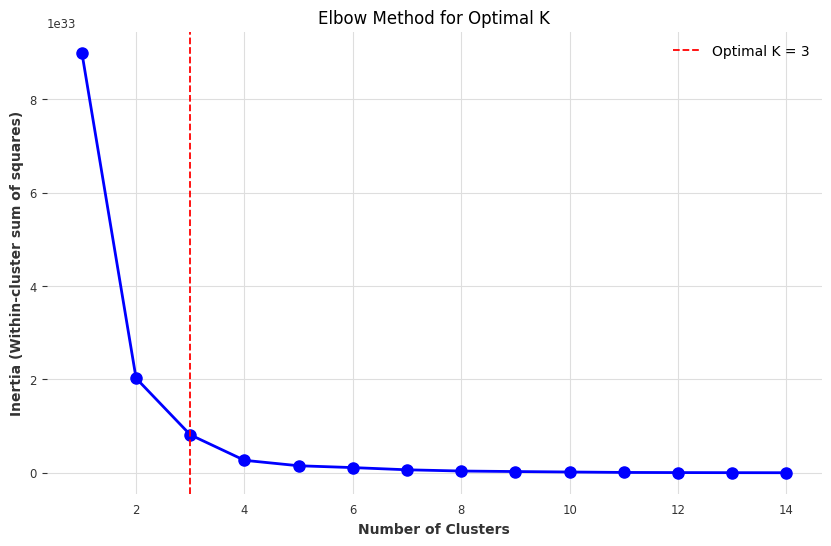

Оптимальное число кластеров: 3


In [27]:
# Масштабируем признаки
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filtered)

# Метод локтя
inertia = []
k_range = range(1, 15)  # пробуем от 1 до 14 кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_filtered)
    inertia.append(kmeans.inertia_)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

# Находим "локоть" автоматически
from kneed import KneeLocator
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

plt.axvline(x=optimal_k, color='red', linestyle='--', 
           label=f'Optimal K = {optimal_k}')
plt.legend()
plt.show()

print(f"Оптимальное число кластеров: {optimal_k}")

In [28]:
# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_filtered)

# Создаем маппинг segment -> cluster
segment_to_cluster = pd.Series(cluster_labels, index=features_filtered.index, name='cluster')

# Добавляем кластеры к основному датафрейму
perfect_df = perfect_df.merge(segment_to_cluster, left_on='segment', right_index=True)

perfect_describe = perfect_describe.merge(segment_to_cluster, left_on='segment', right_index=True)

In [29]:
perfect_df

,segment,timestamp,target,cluster
197,АДКМ_4 воды_4 воды Виноградная Питьевая вода ...,2022-04-30,27.0,0
198,АДКМ_4 воды_4 воды Виноградная Питьевая вода ...,2022-05-31,44.0,0
199,АДКМ_4 воды_4 воды Виноградная Питьевая вода ...,2022-06-30,135.0,0
200,АДКМ_4 воды_4 воды Виноградная Питьевая вода ...,2022-07-31,52.0,0
201,АДКМ_4 воды_4 воды Виноградная Питьевая вода ...,2022-08-31,92.0,0
...,...,...,...,...
51723,прочее_Ведерников игристое_Ведерников игристое...,2024-03-31,86.0,0
51724,прочее_Ведерников игристое_Ведерников игристое...,2024-04-30,565.0,0
51725,прочее_Ведерников игристое_Ведерников игристое...,2024-05-31,27.0,0
51726,прочее_Ведерников игристое_Ведерников игристое...,2024-06-30,21.0,0


In [30]:
group_df = perfect_df[perfect_df['cluster'] == 2]

fig = px.line(
    group_df,
    x='timestamp',
    y='target',
    color='segment',
    title='Продажи по SKU',
    labels={'target': 'Продажи', 'date': 'Дата'},
    template='plotly_white'
)

#fig.update_layout(
#    hovermode='x unified',
#    legend_title_text='SKU',
#    height=600,
#    width=1000
#)

fig.show()

In [287]:
anomalies.to_dataframe()

,target
timestamp,
2022-01-31,0.0
2022-02-28,0.0
2022-03-31,0.0
2022-04-30,0.0
2022-05-31,0.0
2022-06-30,0.0
2022-07-31,0.0
2022-08-31,0.0
2022-09-30,0.0


In [32]:
perfect_df[perfect_df['cluster'] == 2]['target'].plot(kind='hist')

In [33]:
second_cluster = perfect_df[perfect_df['cluster'] == 2]

In [84]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from scipy import stats

In [36]:
second_cluster

,segment,timestamp,target,cluster
25400,"ТД Регион_РШ_РШ Белое Брют 0,75",2022-01-31,85164.0,2
25401,"ТД Регион_РШ_РШ Белое Брют 0,75",2022-02-28,123879.0,2
25402,"ТД Регион_РШ_РШ Белое Брют 0,75",2022-03-31,182147.0,2
25403,"ТД Регион_РШ_РШ Белое Брют 0,75",2022-04-30,77463.0,2
25404,"ТД Регион_РШ_РШ Белое Брют 0,75",2022-05-31,109422.0,2
...,...,...,...,...
44495,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",2025-04-30,6528.0,2
44496,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",2025-05-31,14976.0,2
44497,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",2025-06-30,94080.0,2
44498,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",2025-07-31,130944.0,2


In [40]:
first_ts = second_cluster[second_cluster['segment'] == 'ТД Регион_РШ_РШ  Белое Брют 0,75']

In [169]:
def find_pacf_lags(series, segment, max_lags=22, alpha=0.05, method='ols'):

    
    pacf_values = pacf(series, nlags=max_lags, method=method)

    # Рассчитываем доверительные интервалы как в plot_pacf
    n = len(series)
    
    # Используем z-score для заданного alpha (двусторонний тест)
    z_score = stats.norm.ppf(1 - alpha/2)
    conf_int_bound = z_score / np.sqrt(n)

    lags = range(len(pacf_values))
    lower_bound = [-conf_int_bound] * len(pacf_values)
    upper_bound = [conf_int_bound] * len(pacf_values)


    
    pacf_df = pd.DataFrame({
        'lags': lags,
        'pacf': pacf_values,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'segment':segment,
        'lag_kind':'sign_pacf'
    })
    
    pacf_df['is_sign'] = (pacf_df['pacf'] > pacf_df['upper_bound']) | (pacf_df['pacf'] < pacf_df['lower_bound'])

    ts = TimeSeries.from_dataframe(series, freq='M')

    seasonal_list = []

    for i in range(2, max_lags):
        season_tuple = check_seasonality(ts, m=i, max_lag=max_lags)
        if season_tuple[0] == True:
            seasonal_list.append(season_tuple[1])

    seasonal_df = pd.DataFrame({
        'lags': seasonal_list,
        'segment':segment,
        'lag_kind':'cheack_seasonality',
        'is_sign':True
    })

    # Исключаем лаг 0 (он всегда равен 1 и всегда значим)
    sign_lags = pacf_df[pacf_df['is_sign'] & (pacf_df['lags'] > 0)]['lags'].tolist()

    result_df = pd.concat([pacf_df, seasonal_df])

    
    
    return sign_lags, result_df

In [162]:
pacf_df

,lags,pacf,lower_bound,upper_bound,segment,is_sign
0,0,1.000000,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",True
1,1,0.335027,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",True
2,2,0.240377,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",False
3,3,-0.208982,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",False
4,4,-0.306026,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",True
5,5,-0.136315,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",False
6,6,-0.200742,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",False
7,7,-0.358052,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",True
8,8,-0.359815,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",True
9,9,-0.115522,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",False


In [91]:
sign_lags, pacf_df = find_pacf_lags(first_ts[['target']])

In [170]:
lags_list = []

for i in second_cluster['segment'].unique():
    segment_df = second_cluster[second_cluster['segment'] == i]
    _, pacf_df = find_pacf_lags(segment_df[['timestamp', 'target']].set_index('timestamp'), i) 
    lags_list.append(pacf_df)

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' 

In [171]:
lags_describe = pd.concat(lags_list)

lags_describe

,lags,pacf,lower_bound,upper_bound,segment,lag_kind,is_sign
0,0,1.000000,-0.295476,0.295476,"ТД Регион_РШ_РШ Белое Брют 0,75",sign_pacf,True
1,1,0.627341,-0.295476,0.295476,"ТД Регион_РШ_РШ Белое Брют 0,75",sign_pacf,True
2,2,-0.145778,-0.295476,0.295476,"ТД Регион_РШ_РШ Белое Брют 0,75",sign_pacf,False
3,3,-0.352818,-0.295476,0.295476,"ТД Регион_РШ_РШ Белое Брют 0,75",sign_pacf,True
4,4,-0.271009,-0.295476,0.295476,"ТД Регион_РШ_РШ Белое Брют 0,75",sign_pacf,False
...,...,...,...,...,...,...,...
19,19,-0.402488,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",sign_pacf,True
20,20,0.599158,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",sign_pacf,True
21,21,3.809720,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",sign_pacf,True
22,22,-2.777737,-0.295476,0.295476,"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",sign_pacf,True


In [210]:
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, remove_seasonality, remove_trend, plot_hist
from darts.utils.utils import SeasonalityMode

In [202]:
SeasonalityMode.ADDITIVE

<SeasonalityMode.ADDITIVE: 'additive'>

In [111]:
first_ts_ts = TimeSeries.from_dataframe(first_ts.drop(['segment', 'cluster'], axis=1), time_col='timestamp', freq='M')

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



<Axes: xlabel='timestamp'>

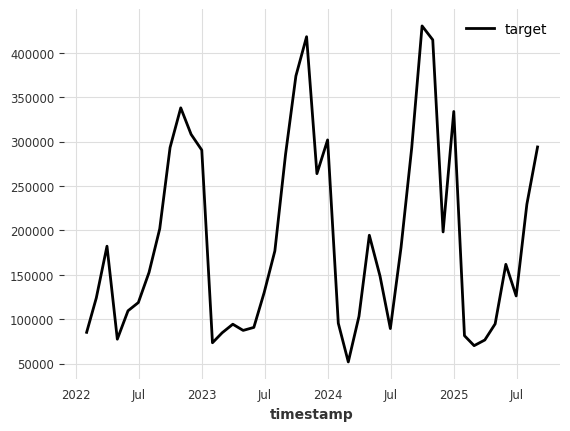

In [192]:
first_ts_ts.plot()

<Axes: xlabel='timestamp'>

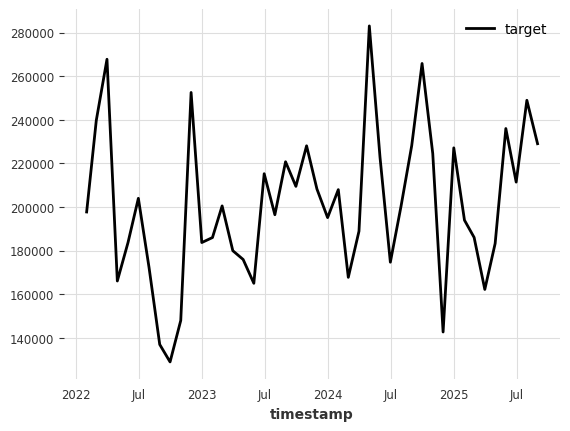

In [238]:
remove_seasonality(first_ts_ts, model=SeasonalityMode.ADDITIVE, method='naive', freq=12).plot()

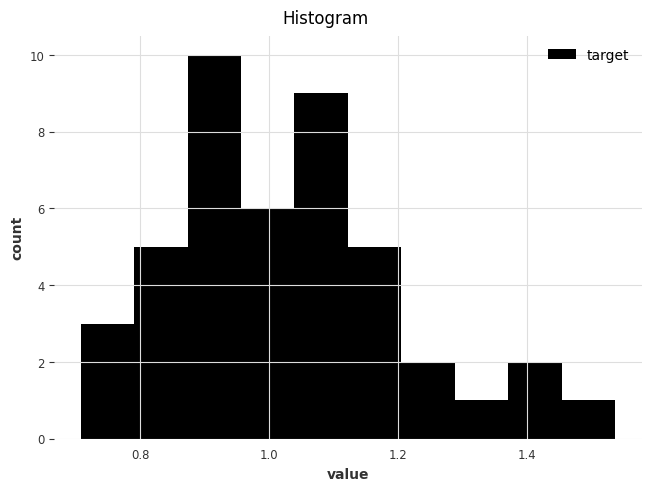

In [239]:
plot_hist(remove_trend(remove_seasonality(first_ts_ts, model=SeasonalityMode.ADDITIVE, method='naive', freq=12)))

In [123]:
seasonal_list = []

for i in range(2, 25):
    season_tuple = check_seasonality(first_ts_ts, m=i, max_lag=24)
    seasonal_list.append(season_tuple)

In [155]:
season_tuple[1]

24

In [124]:
seasonal_list

[(False, 2),
 (False, 3),
 (False, 4),
 (False, 5),
 (False, 6),
 (False, 7),
 (False, 8),
 (False, 9),
 (False, 10),
 (False, 11),
 (True, 12),
 (False, 13),
 (False, 14),
 (False, 15),
 (False, 16),
 (False, 17),
 (False, 18),
 (False, 19),
 (False, 20),
 (False, 21),
 (False, 22),
 (False, 23),
 (False, 24)]

In [ ]:
def find_pacf_lags(series, segment, max_lags=22, alpha=0.05, method='ols'):

    
    pacf_values = pacf(series, nlags=max_lags, method=method)

    # Рассчитываем доверительные интервалы как в plot_pacf
    n = len(series)
    
    # Используем z-score для заданного alpha (двусторонний тест)
    z_score = stats.norm.ppf(1 - alpha/2)
    conf_int_bound = z_score / np.sqrt(n)

    lags = range(len(pacf_values))
    lower_bound = [-conf_int_bound] * len(pacf_values)
    upper_bound = [conf_int_bound] * len(pacf_values)
    
    pacf_df = pd.DataFrame({
        'lags': lags,
        'pacf': pacf_values,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'segment':segment
    })
    
    pacf_df['is_sign'] = (pacf_df['pacf'] > pacf_df['upper_bound']) | (pacf_df['pacf'] < pacf_df['lower_bound'])

    # Исключаем лаг 0 (он всегда равен 1 и всегда значим)
    sign_lags = pacf_df[pacf_df['is_sign'] & (pacf_df['lags'] > 0)]['lags'].tolist()
    
    return sign_lags, pacf_df

In [107]:
import seaborn as sns

In [183]:
lags_describe[(lags_describe['is_sign'] == True) & (lags_describe['lags'] >= 6)]['lags'].value_counts().to_frame().sort_values(by='count', ascending=False)

,count
lags,
12,11
22,5
20,5
21,4
7,3
8,3
13,2
17,2
14,2


<Axes: ylabel='lags'>

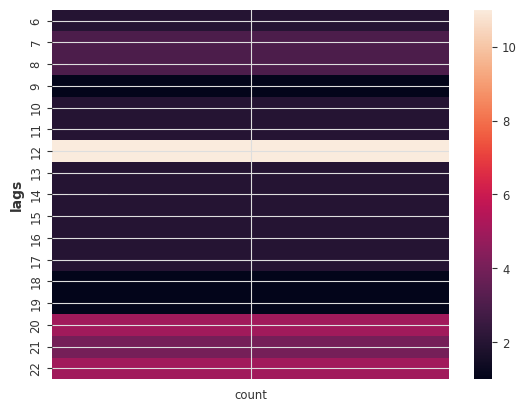

In [173]:
sns.heatmap(lags_describe[(lags_describe['is_sign'] == True) & (lags_describe['lags'] >= 6)]['lags'].value_counts().to_frame().sort_index())

In [100]:
lags_describe[lags_describe['is_sign'] == True].pivot_table(index='segment', columns='lags', values='is_sign', fill_value=0)

lags,0,1,2,3,4,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
segment,,,,,,,,,,,,,,,,,,,,,
"ТД Регион_РШ_РШ Белое Брют 0,75",1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"ТД Регион_РШ_РШ Белое Полусладкое 0,75",1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
"ТД Сети Х5_РШ_РШ Белое Брют 0,75",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
"ТД Сети Х5_РШ_РШ Белое Полусладкое 0,75",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
"ТД Сети_РШ_РШ Белое Брют 0,75",1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
"ТД Юг Сети_РШ_РШ Белое Полусладкое 0,75",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [ ]:
pacf_values, conf_int = pacf(first_ts[['target']], nlags=22, alpha=0.1, method='ols')

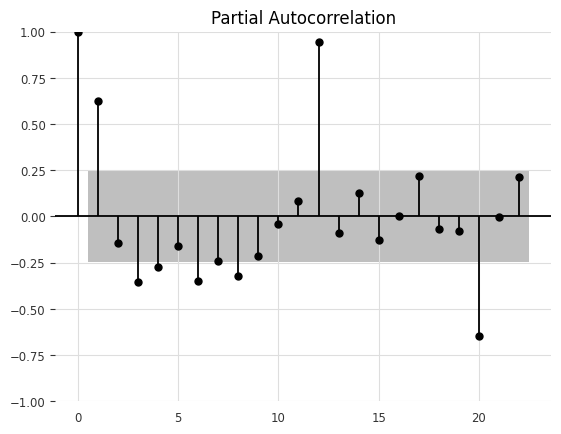

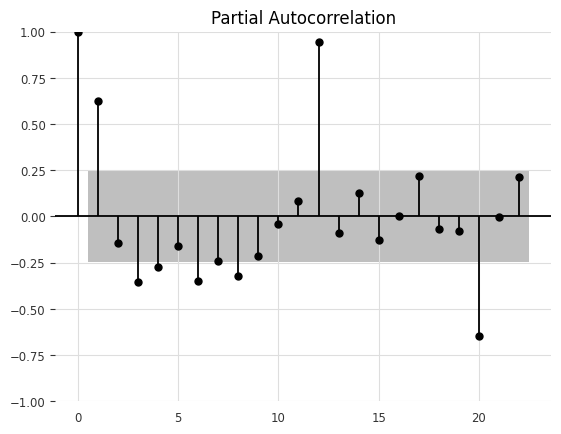

In [80]:
plot_pacf(first_ts[['target']], lags=22, method='ols', alpha=0.1)

In [75]:
conf_int[12]

array([0.6467782 , 1.23772958])

In [76]:
pacf_values[12]

0.9422538919676512

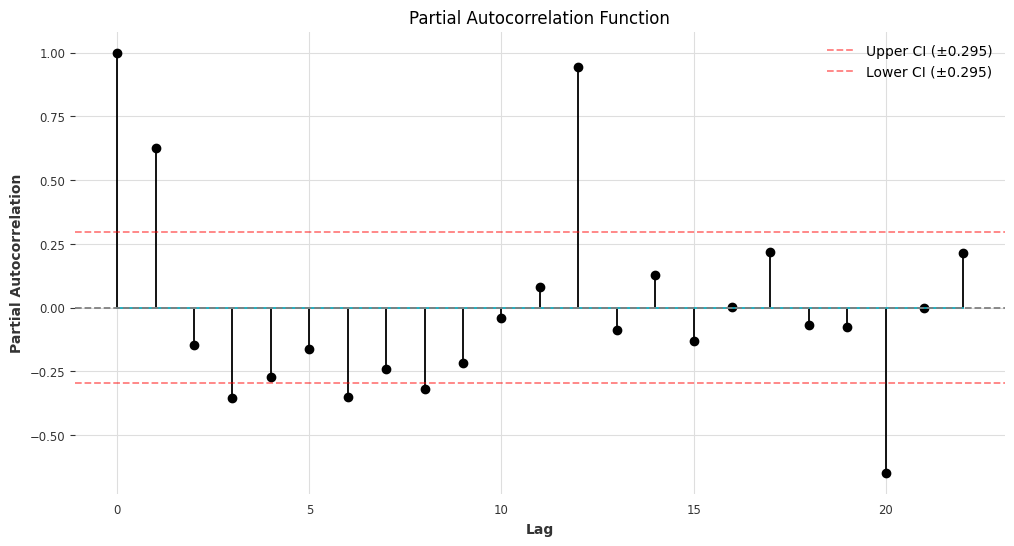

Значимые лаги (|PACF| > 0.295):
Лаг 0: 1.0000
Лаг 1: 0.6273
Лаг 3: -0.3528
Лаг 6: -0.3494
Лаг 8: -0.3206
Лаг 12: 0.9423
Лаг 20: -0.6473


In [81]:
# Получаем только значения PACF без доверительных интервалов
pacf_values = pacf(first_ts[['target']], nlags=22, method='ols')

# Рассчитываем доверительные интервалы как в plot_pacf
n = len(first_ts)
conf_int_manual = 1.96 / np.sqrt(n)  # ±1.96/√n

# Строим график вручную
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=conf_int_manual, linestyle='--', color='red', alpha=0.5, label=f'Upper CI (±{conf_int_manual:.3f})')
plt.axhline(y=-conf_int_manual, linestyle='--', color='red', alpha=0.5, label=f'Lower CI (±{conf_int_manual:.3f})')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.legend()
plt.show()

# Проверяем значимые лаги
significant_lags = []
for i, value in enumerate(pacf_values):
    if abs(value) > conf_int_manual:
        significant_lags.append((i, value))

print(f"Значимые лаги (|PACF| > {conf_int_manual:.3f}):")
for lag, value in significant_lags:
    print(f"Лаг {lag}: {value:.4f}")

In [45]:
first_ts[['timestamp', 'target']].set_index('timestamp').shape

(44, 1)

In [126]:
from etna.analysis import get_anomalies_density
from etna.analysis import get_anomalies_median
from etna.analysis import plot_anomalies

In [127]:
second_cluster['segment'].unique()

array(['ТД Регион_РШ_РШ  Белое Брют 0,75',
       'ТД Регион_РШ_РШ  Белое Полусладкое 0,75',
       'ТД Сети Х5_РШ_РШ  Белое Брют 0,75',
       'ТД Сети Х5_РШ_РШ  Белое Полусладкое 0,75',
       'ТД Сети_РШ_РШ  Белое Брют 0,75',
       'ТД Юг Сети_РШ_РШ  Белое Полусладкое 0,75'], dtype=object)

In [261]:
test_outliers = second_cluster[second_cluster['segment'] == 'ТД Юг Сети_РШ_РШ  Белое Полусладкое 0,75']

ts_outliers = TSDataset(test_outliers.drop('cluster', axis=1), freq="M")

C:\Users\Kruglov\AppData\Roaming\Python\Python311\site-packages\etna\datasets\tsdataset.py:145: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [262]:
ts_outliers = TimeSeries.from_dataframe(test_outliers.drop(['segment', 'cluster'], axis=1), time_col='timestamp', freq='M')

c:\Users\Kruglov\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\timeseries.py:5108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [275]:
from darts.models import RegressionModel
from darts.ad import QuantileDetector

In [279]:
model = QuantileDetector(
    low_quantile=0.05,  # Встроенная прогнозная модель
    high_quantile=0.95  # Параметр для скоррера
)

# Обучаем и получаем бинарные метки аномалий
model.fit(ts_outliers)

anomalies = model.detect(ts_outliers)

,target
timestamp,
2022-01-31,0.0
2022-02-28,0.0
2022-03-31,0.0
2022-04-30,0.0
2022-05-31,0.0
2022-06-30,0.0
2022-07-31,0.0
2022-08-31,0.0
2022-09-30,0.0


<Axes: xlabel='timestamp'>

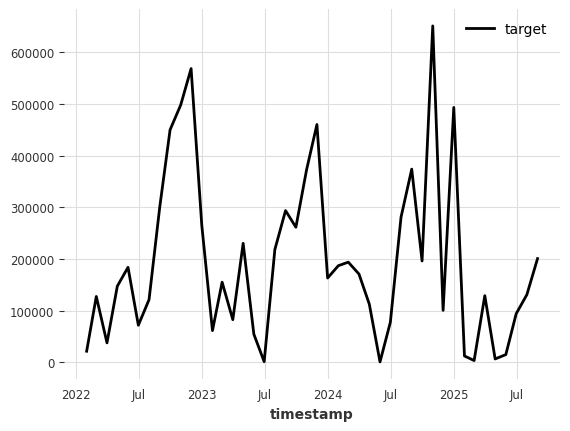

In [282]:
ts_outliers.plot()

In [263]:
resids_ts = remove_trend(remove_seasonality(ts_outliers, freq=12))

In [264]:
resids_ts = resids_ts.to_dataframe().reset_index()

resids_ts['segment'] = 'a'

In [265]:
ts_outliers_ts = TSDataset(resids_ts, freq="M")

C:\Users\Kruglov\AppData\Roaming\Python\Python311\site-packages\etna\datasets\tsdataset.py:145: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



<Axes: xlabel='timestamp'>

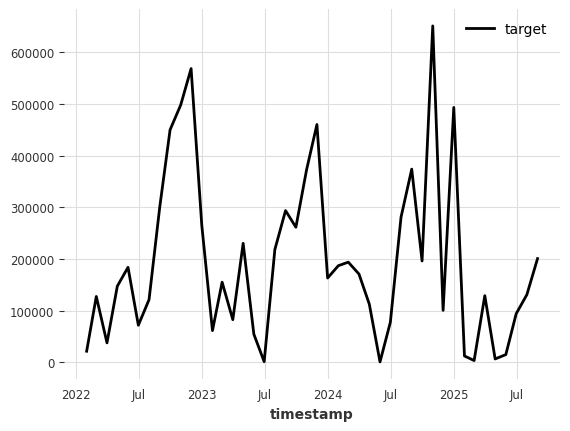

In [266]:
ts_outliers.plot()

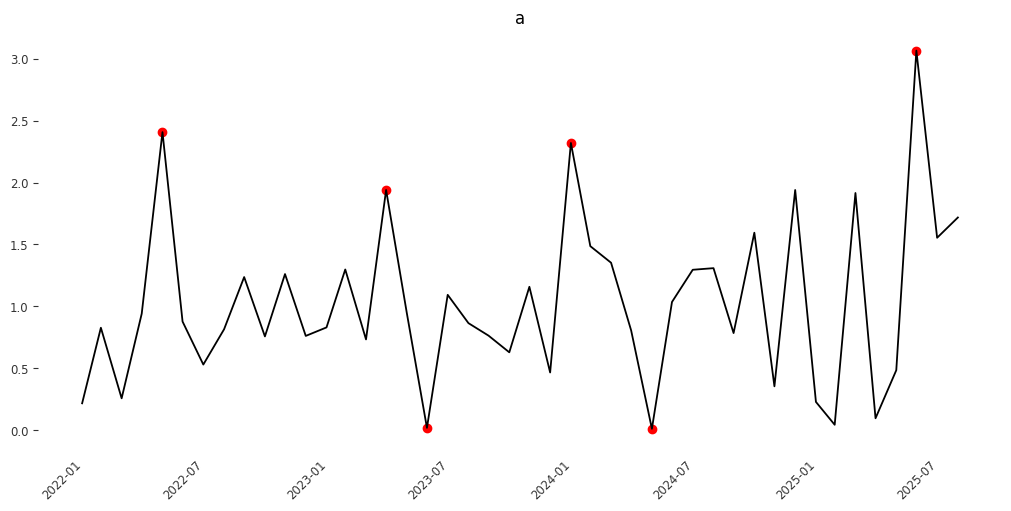

In [270]:
anomaly_dict = get_anomalies_density(ts_outliers_ts, distance_coef=1, window_size=6, n_neighbors=2)
plot_anomalies(ts_outliers_ts, anomaly_dict)

In [269]:
anomaly_dict

{'a': [numpy.datetime64('2022-05-31T00:00:00.000000000'),
  numpy.datetime64('2025-06-30T00:00:00.000000000')]}

In [276]:
from ruptures.detection import Binseg

from etna.analysis import find_change_points
from etna.analysis import plot_change_points_interactive
from etna.analysis import plot_time_series_with_change_points

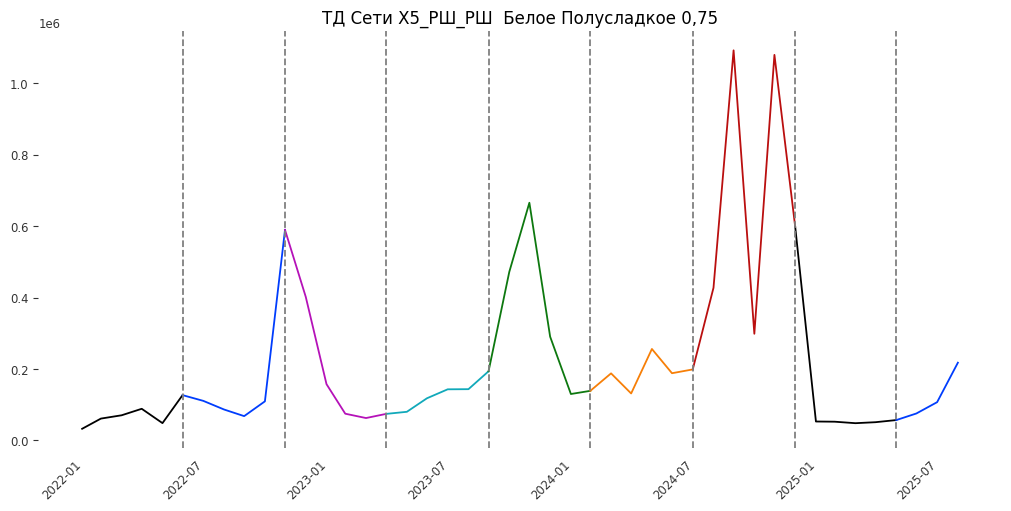

In [277]:
change_points = find_change_points(ts=ts_outliers, in_column="target", change_point_model=Binseg(), pen=1e5)
plot_time_series_with_change_points(ts=ts_outliers, change_points=change_points)